# Load modules

In [51]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
import re
import requests
import os
import pickle

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')   

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Aux functions

In [2]:
import glob
import random
import base64

from PIL import Image
from io import BytesIO
from IPython.display import HTML
import io

# Remove salts from molecules and replace <mol> with the cleaner version
from rdkit.Chem.SaltRemover import SaltRemover 
# Add Inchi and inchikeys to the molecules for further aggregation
from rdkit.Chem.inchi import MolToInchi
from rdkit.Chem.inchi import InchiToInchiKey

def get_thumbnail(path):
    path = "\\\\?\\"+path # This "\\\\?\\" is used to prevent problems with long Windows paths
    i = Image.open(path)    
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'png')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

def link_formatter(listset):    
    
    li = []
    if len(listset) > 1 :
        for i in listset : 
            alist = i.split(",")
            if len(alist) > 1 :
                for a in alist :                     
                    li.append(a)
            else :
                li.append(alist[0])
    else :         
        li.append(list(listset)[0])

    pset = set(li)
    tag = '<ul>'    
        
    for a in pset :
        aset = a.split(",")
        if len(aset) > 1 :
            for i in aset :
                if re.search(".+/(MolPort.+)", i) :                                 
                    tag += f'<li><a href="{i}">Molport</a></li>'
                else :
                    tag += f'<li><a href="{i}">Hit2Lead</a></li>'
        else :
            if re.search(".+/(MolPort.+)", a) :                                 
                tag += f'<li><a href="{a}">Molport</a></li>'
            else :
                tag += f'<li><a href="{a}">Hit2Lead</a></li>'                        
    tag +='</ul>'
    return tag    

def set_formatter(aset):    
    
    tag = '<ul style="text-align:left;">'
    for a in aset :
        tag += f'<li>{a}</li>'
    tag +='</ul>'
    return tag   


def countCarbons(smiles) :
    pattern = '[cC]'
    carbons = len(re.findall(pattern, smiles))
    return carbons

def fragmentedMols(smiles) :     
    pattern = '\.'
    try : 
        fragments = len(re.findall(pattern, smiles))
        return fragments
    except :
        return np.nan

def safe_molFromSmiles(smiles) : 
    try :
        mol = Chem.MolFromSmiles(smiles)
        return mol
    except :
        return np.nan
    
def safe_removeSalts(mol) :
    try :
        mol = SaltRemover().StripMol(mol,dontRemoveEverything=True)
    except : 
        mol = np.nan
    return mol

def safe_mol_to_inchi(mol) :
    try :
        inchi = MolToInchi(mol)
    except : 
        inchi = np.nan
    return inchi

def safe_inchi_to_inchikey(inchi) :
    try :
        inchikey = InchiToInchiKey(inchi)
    except : 
        inchikey = np.nan
    return inchikey    
    
def SDF2DF (file=None, sanitize=True):
    
    mols= Chem.SDMolSupplier(file, sanitize=sanitize)
    mols_df_list = []
    
    for mol in mols :
        
        try :
        
            mol_df = pd.DataFrame(mol.GetPropsAsDict(), index=[0])
            mols_df_list.append(mol_df)
        except :
            pass

    mols_df = pd.concat(mols_df_list)
        
    return mols_df



def drugNames (smiles) :
    
    if re.search("\.",smiles) :
    
        smiles = smiles.split("\.")[0]
    
    url = "https://cactus.nci.nih.gov/chemical/structure/{}/names".format(smiles)
    response = requests.get(url)
    
    if response.status_code == 200 :
        if response.text.split("\n")[0] == '<!DOCTYPE html>' : 
            return None
        else :
            return response.text.split("\n")
    else :
        return None

import requests
import pandas as pd
import math

def retrieve_price(mp_id,minimum) :
    
    print(mp_id)

    try :
        
        r = retrieve_mpdata(mp_id)
        t = []
        
        for prod in r["Screening Block Suppliers"] :
            prod = dict(prod)        
            try : 
                for catalog in prod["Catalogues"] :
                    try : 
                        for packing in catalog["Available Packings"] :
                            try : 
                                if packing["Measure"] != "mg" :
                                    continue
                                if packing["Amount"] < minimum :
                                    continue
                                t.append(pd.DataFrame.from_dict(packing, orient="index").transpose())
                            except : 
                                continue
                    except : 
                        continue
            except : 
                continue  
                
        for prod in r['Building Block Suppliers'] :
            prod = dict(prod)        
            try : 
                for catalog in prod["Catalogues"] :
                    try : 
                        for packing in catalog["Available Packings"] :
                            try : 
                                if packing["Measure"] != "mg" :
                                    continue
                                if packing["Amount"] < minimum :
                                    continue                                    
                                t.append(pd.DataFrame.from_dict(packing, orient="index").transpose())
                            except : 
                                continue
                    except : 
                        continue
            except : 
                continue                     
        
        data = pd.concat(t)
        data["dist_to_min"] = data.apply(lambda x : x["Amount"]-minimum ,axis=1)        
        
        # Filtro por la presentación más conveniente
        data = data.iloc[data["dist_to_min"].argmin()]
        data["buy"] = math.ceil(minimum/data["Amount"])
        data["cost"] = data["Price"]*data["buy"]
        print(f"Min (mg): {minimum} mg \nPacking (mg) {data['Amount']}\nCantidad: {data['buy']}\nTotal: {data['cost']}")
        return data["cost"]
    except Exception as e:
        return f"Error API {e}"
    
def retrieve_mpdata(mp_id) :
    
    username = "john.spade"
    authcode = "fasdga34a3"
    
    url = f'http://api.molport.com/api/molecule/load?molecule={mp_id}&username={username}&authenticationcode={authcode}'
    r = requests.get(url)
    
    t = pd.DataFrame.from_dict(r.json()["Data"]).loc["Catalogues"]["Molecule"]
    

    return t    

 # Load datasets
 

In [4]:
# Set root 
root = "../Data"

In [5]:
ndpi_file = f"{root}/interactions/ortholog-ndpi-library_notryp.csv"
ndpi = pd.read_csv(ndpi_file,sep="\t")[['mol_id','smiles','known_target','known_target_product','known_target_species','gene_name']]
cherry_picked_targets = pd.read_csv(f"{root}/targets/tcr_cherrypicked_routes.csv", sep="\t",)[["gene_name","gene_product"]]
tcr_targets_full = pd.read_csv(f"{root}/targets/tcr_targest.csv",sep="\t")[["omcl","nds_tier","gene_name","gene_product"]]
ndpi = pd.merge(ndpi,tcr_targets_full,how="inner",on="gene_name")


In [7]:
ndpi["mol"] = ndpi.apply(lambda x : safe_molFromSmiles(x["smiles"]),axis=1)
ndpi["mol"] = ndpi.apply(lambda x: safe_removeSalts(x["mol"]),axis=1)
ndpi.drop(index=ndpi[ndpi["mol"]==np.nan].index,inplace=True)
ndpi["inchi"] = ndpi.apply(lambda x: safe_mol_to_inchi(x["mol"]),axis=1)
ndpi.drop(index=ndpi[ndpi["inchi"]==np.nan].index,inplace=True)
ndpi["inchikey"] = ndpi.apply(lambda x: safe_inchi_to_inchikey(x["inchi"]),axis=1)

In [8]:
compounds = ndpi.groupby(["inchikey","smiles","mol_id"]).agg({"mol":set}).reset_index()
compounds["smiles"].to_csv("compounds.smiles",index=False,header=False)

```MySQL
SELECT m.mol_id, g.gene_name AS known_target, g.gene_product AS known_target_product, g.species_code AS known_target_species, g2.gene_name, g.gene_product, g.nds_species_tier, m.smiles FROM moldata m JOIN gene_drug_interactions gdi on gdi.mol_id = m.mol_id JOIN genes g on g.gene_id = gdi.gene_id JOIN genes g2 on g.orthomcl_clusterid = g2.orthomcl_clusterid WHERE g2.species_code = 'tcr' AND m.mol_id NOT IN (SELECT xgdi.mol_id FROM gene_drug_interactions xgdi JOIN genes xg ON xg.gene_id = xgdi.gene_id WHERE xg.species_code IN ('tcr','tbr','lma') ) AND gdi.activity_tag = '+' GROUP BY gdi.mol_id;"
```

# Tested and Drugbank annotated drugs



In [9]:
li = []

files = {
    "TDR" :  '../Data/tested/tested.drugs.tryps.wupdate.smiles',
    "Nieves" :  '../Data/tested/tested.drugs.tryp.nieves.smiles',    
    "Fleau" :  '../Data/tested/tested.drugs.tryp.fleau.smiles',    
    
}

for src, filename in files.items():
    df = pd.read_csv(filename, sep="\t", names=["smiles"])[1:]
    df["source"] = src
    li.append(df)

tested = pd.concat(li, axis=0, ignore_index=True)
tested["mol"] = tested.apply(lambda x : Chem.MolFromSmiles(x["smiles"]),axis=1)

# Remove salts from molecules and replace <mol> with the cleaner version
from rdkit.Chem.SaltRemover import SaltRemover 
tested["mol"] = tested.apply(lambda x: SaltRemover().StripMol(x["mol"],dontRemoveEverything=True),axis=1)

# Add Inchi and inchikeys to the molecules for further aggregation
from rdkit.Chem.inchi import MolToInchi
from rdkit.Chem.inchi import InchiToInchiKey
tested["inchi"] = tested.apply(lambda x: MolToInchi(x["mol"]),axis=1)
tested["inchikey"] = tested.apply(lambda x: InchiToInchiKey(x["inchi"]),axis=1)


In [10]:
drugbank=SDF2DF("../Data/drugbank/structures.sdf")
drugbank

DATABASE_ID DATABASE_NAME  \
0      DB00006      drugbank   
0      DB00007      drugbank   
0      DB00014      drugbank   
0      DB00027      drugbank   
0      DB00035      drugbank   
..         ...           ...   
0      DB16400      drugbank   
0      DB16403      drugbank   
0      DB16404      drugbank   
0      DB16406      drugbank   
0      DB16408      drugbank   

                                               SMILES  \
0   CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...   
0   CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...   
0   CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...   
0   CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...   
0   NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...   
..                                                ...   
0   [H][C@@]1(O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1O)...   
0   [H][C@@]1(O[C@@H](OC2=C(OC3=C(C(O)=CC(O)=C3)C2...   
0                              CC(C)C1=CC(O)=C(C)C=C1   
0   CC1=C(C=C(S1)C(=O)C1=C(N[C@H]2C[C@H](O)[C@@H](...   
0   COC1=NC(OC)=C2C(O[C@]3([C@@H]([C@@H](CN(C)C)[C...   

                                     INCHI_IDENTIFIER  \
0   InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...   
0   InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...   
0   InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...   
0   InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...   
0   InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...   
..                                                ...   
0   InChI=1S/C35H39NO11/c1-18(39)36-12-10-35(11-13...   
0   InChI=1S/C21H20O12/c22-6-12(27)19-16(29)17(30)...   
0   InChI=1S/C10H14O/c1-7(2)9-5-4-8(3)10(11)6-9/h4...   
0   InChI=1S/C25H28ClN5O5S2/c1-13-18(23-19-7-16(26...   
0   InChI=1S/C28H29N3O5/c1-31(2)16-20-23(18-8-6-5-...   

                      INCHI_KEY         FORMULA  MOLECULAR_WEIGHT  \
0   OIRCOABEOLEUMC-GEJPAHFPSA-N   C98H138N24O33         2180.2853   
0   GFIJNRVAKGFPGQ-LIJARHBVSA-N    C59H84N16O12         1209.3983   
0   BLCLNMBMMGCOAS-URPVMXJPSA-N    C59H84N18O14         1269.4105   
0   NDAYQJDHGXTBJL-MWWSRJDJSA-N   C96H135N19O16         1811.2530   
0   NFLWUMRGJYTJIN-PNIOQBSNSA-N  C46H64N14O12S2         1069.2200   
..                          ...             ...               ...   
0   SFHMWDMKUYVSQJ-VECBPBMLSA-N      C35H39NO11          649.6930   
0   OPJZLUXFQFQYAI-GNPVFZCLSA-N       C21H20O12          464.3790   
0   RECUKUPTGUEGMW-UHFFFAOYSA-N         C10H14O          150.2210   
0   LXRZVMYMQHNYJB-UNXOBOICSA-N  C25H28ClN5O5S2          578.1000   
0   QYCXWOACFWMQFO-WZWZCULESA-N      C28H29N3O5          487.5560   

     EXACT_MASS  JCHEM_ACCEPTOR_COUNT  JCHEM_AVERAGE_POLARIZABILITY  ...  \
0   2178.985813                    37                    215.455603  ...   
0   1208.645462                    16                    126.802615  ...   
0   1268.641439                    18                    131.221183  ...   
0   1810.033419                    16                    194.731121  ...   
0   1068.426956                    15                    104.780422  ...   
..          ...                   ...                           ...  ...   
0    649.252311                    11                     70.137764  ...   
0    464.095476                    12                     43.324739  ...   
0    150.104465                     1                     17.863887  ...   
0    577.122039                     9                     58.690144  ...   
0    487.210721                     8                     51.733752  ...   

                 SECONDARY_ACCESSION_NUMBERS                DRUG_GROUPS  \
0    BTD00076; EXPT03302; BIOD00076; DB02351  approved; investigational   
0                        BTD00009; BIOD00009  approved; investigational   
0                        BTD00113; BIOD00113                   approved   
0                        BTD00036; BIOD00036                   approved   
0   BTD00112; BTD00061; BIOD00112; BIOD00061                   approved   
..                                       ...            

In [12]:
drugbank_inset = pd.merge(ndpi,drugbank, left_on="inchikey", right_on="INCHI_KEY",how="inner")
drugbank_inset



mol_id                                             smiles  \
0         149   FCCn1cc(C(=O)O)c(=O)c2c1c(F)c(N1CCN(CC1)C)c(c2)F   
1        1621  NCC1CN(C/C/1=N\\OC)c1nc2c(cc1F)c(=O)c(cn2C1CC1...   
2       15337   NC1CCN(C1)c1c(F)cc2c(c1Cl)n(cc(c2=O)C(=O)O)C1CC1   
3       47954  CO[C@@H]1[C@@H](OC(=O)N)[C@@H](O)[C@@H](OC1(C)...   
4       57078             CCn1cc(C(=O)O)c(=O)c2c1cc(cc2)c1ccncc1   
...       ...                                                ...   
1874  1781133  Cc1nn(c(n1)c1cn2c(n1)c1ccc(cc1OCC2)c1cnn(c1)C(...   
1875  1270241  COc1cc2nccc(c2cc1C(=O)N)Oc1ccc(c(c1)Cl)NC(=O)N...   
1876  1142168                 O[C@@H]([C@H](C(=O)O)O)COP(=O)(O)O   
1877  1136223  C[C@H]([C@@H](C(=O)NS(=O)(=O)OC[C@H]1O[C@H]([C...   
1878  1216308  CCNC(=O)C[C@@H]1N=C(c2ccc(cc2)Cl)c2c(n3c1nnc3C...   

         known_target                               known_target_product  \
0               b3699                             DNA gyrase, subunit B    
1               b3699                             DNA gyrase, subunit B    
2               b3699                             DNA gyrase, subunit B    
3               b3699                             DNA gyrase, subunit B    
4               b3699                             DNA gyrase, subunit B    
...               ...                                                ...   
1874             5289  phosphatidylinositol 3-kinase, catalytic subun...   
1875  ENSG00000170759                           kinesin family member 5B   
1876  ENSG00000142657                    phosphogluconate dehydrogenase    
1877  ENSG00000113407                          threonyl-tRNA synthetase    
1878  ENSG00000156802            ATPase family, AAA domain containing 2    

     known_target_species         gene_name        omcl  nds_tier  \
0                     eco   TcCLB.506445.60  OG5_128755         5   
1                     eco   TcCLB.506445.60  OG5_128755         5   
2                     eco   TcCLB.506445.60  OG5_128755         5   
3                     eco   TcCLB.506445.60  OG5_128755         5   
4                     eco   TcCLB.506445.60  OG5_128755         5   
...                   ...               ...         ...       ...   
1874                  hsa  TcCLB.511903.160  OG5_128181         5   
1875                  hsa   TcCLB.506479.60  OG5_127646         3   
1876                  hsa  TcCLB.507011.269  OG5_127175         4   
1877                  hsa   TcCLB.511181.80  OG5_126764         3   
1878                  hsa  TcCLB.506297.110  OG5_128668         4   

                                           gene_product  \
0          mitochondrial DNA topoisomerase II, putative   
1          mitochondrial DNA topoisomerase II, putative   
2          mitochondrial DNA topoisomerase II, putative   
3          mitochondrial DNA topoisomerase II, putative   
4          mitochondrial DNA topoisomerase II, putative   
...                                                 ...   
1874           phosphatidylinositol 3-kinase vps34-like   
1875                      kinesin heavy chain, putative   
1876  6-phosphogluconate dehydrogenase, decarboxylating   
1877                 threonyl-tRNA synthetase, putative   
1878                                   ATPase, putative   

                                                    mol  ...  \
0     <rdkit.Chem.rdchem.Mol object at 0x000002CAA08...  ...   
1     <rdkit.Chem.rdchem.Mol object at 0x000002CAA08...  ...   
2     <rdkit.Chem.rdchem.Mol object at 0x000002CAA07...  ...   
3     <rdkit.Chem.rdchem.Mol object at 0x000002CAA07...  ...   
4     <rdkit.Chem.rdchem.Mol object at 0x000002CAA07...  ...   
...                                                 ...  ...   
1874  <rdkit.Chem.rdchem.Mol object at 0x000002CAA15...  ...   
1875  <rdkit.Chem.rdchem.Mol object at 0x000002CAA15...  ...   
1876  <rdkit.Chem.rdchem.Mol object at 0x000002CAA15...  ...   
1877  <rdkit.Chem.rdchem.Mol object at 0x000002CAA15...  ...   
1878  <rdkit.Chem.rdchem.Mol object

In [13]:
tested_inset = pd.merge(ndpi,tested[["inchikey",]], on="inchikey", how="inner")
tested_inset


mol_id                                             smiles  \
0       2012                 CNCCC(c1ccccc1)Oc1ccc(cc1)C(F)(F)F   
1     569275              CNCCC(c1ccccc1)Oc1ccc(cc1)C(F)(F)F.Cl   
2      25874                     CN(CCC=C1c2ccccc2CCc2c1cccc2)C   
3     565726                  CN(CCC=C1c2ccccc2CCc2c1cccc2)C.Cl   
4      52598         CN[C@H]1CC[C@H](c2c1cccc2)c1ccc(c(c1)Cl)Cl   
..       ...                                                ...   
617   592263  CCS(=O)(=O)Nc1ccc2c(c1)/C(=C(\\c1ccccc1)/Nc1cc...   
618   417035   Clc1ccc(cc1)C1CCC(CC1)C1=C(O)c2c(C(=O)C1=O)cccc2   
619  1159590  O[C@H]1CC[C@]2([C@H](C1)CC[C@@H]1[C@@H]2CC[C@]...   
620   378360  C/C=C/C[C@H]([C@H]([C@H]1C(=O)N[C@@H](CC)C(=O)...   
621  1396824  O=C(N(c1nc2c(s1)cccc2)CCCN1CCOCC1)CCS(=O)(=O)c...   

        known_target                       known_target_product  \
0    ENSG00000147955  sigma non-opioid intracellular receptor 1   
1               5901            RAN, member RAS oncogene family   
2    ENSG00000147955  sigma non-opioid intracellular receptor 1   
3    ENSG00000149311               ATM serine/threonine kinase    
4    ENSG00000147955  sigma non-opioid intracellular receptor 1   
..               ...                                        ...   
617     LmxM.36.6290                glucose transporter, lmgt2    
618    PF3D7_1023200       orotidine 5'-phosphate decarboxylase   
619        AT5G13710        cycloartenol-c-24-methyltransferase   
620    PF3D7_0322000        peptidyl-prolyl cis-trans isomerase   
621  ENSG00000185624    prolyl 4-hydroxylase, beta polypeptide    

    known_target_species         gene_name        omcl  nds_tier  \
0                    hsa   TcCLB.510329.90  OG5_131051         5   
1                    hsa   TcCLB.503539.30  OG5_127514         1   
2                    hsa   TcCLB.510329.90  OG5_131051         5   
3                    hsa   TcCLB.506533.34  OG5_128955         4   
4                    hsa   TcCLB.510329.90  OG5_131051         5   
..                   ...               ...         ...       ...   
617                  lme   TcCLB.511041.40  OG5_129633         4   
618                  pfa   TcCLB.508373.29  OG5_126793         5   
619                  ath   TcCLB.505683.10  OG5_129172         4   
620                  pfa   TcCLB.510259.50  OG5_126792         4   
621                  hsa  TcCLB.507611.370  OG5_126843         1   

                                          gene_product  \
0                       C-8 sterol isomerase, putative   
1           GTP-binding nuclear protein rtb2, putative   
2                       C-8 sterol isomerase, putative   
3    phosphatidylinositol kinase related protein, p...   
4                       C-8 sterol isomerase, putative   
..                                                 ...   
617                       hexose transporter, putative   
618  orotidine-5-phosphate decarboxylase/orotate ph...   
619            sterol 24-c-methyltransferase, putative   
620                       21 kDa cyclophilin, putative   
621          bloodstream- specific protein 2 precursor   

                                                   mol  \
0    <rdkit.Chem.rdchem.Mol object at 0x000002CA9C9...   
1    <rdkit.Chem.rdchem.Mol object at 0x000002CA9DA...   
2    <rdkit.Chem.rdchem.Mol object at 0x000002CA9C8...   
3    <rdkit.Chem.rdchem.Mol object at 0x000002CA9DA...   
4    <rdkit.Chem.rdchem.Mol object at 0x000002CA9C8...   
..                                                 ...   
617  <rdkit.Chem.rdchem.Mol object at 0x000002CAA13...   
618  <rdkit.Chem.rdchem.Mol object at 0x000002CAA14...   
619  <rdkit.Chem.rdchem.Mol object at 0x000002CAA14...   
620  <rdkit.Chem.rdchem.Mol object at 0x000002CAA14...   
621  <rdkit.Chem.rdchem.Mol object at 0x000002CAA1D...   

                                                 inchi  \
0    InChI=1S/C17H18F3NO/c1-21-12-11-16(13-5-3-2-4-...   
1    InChI=1S/C17H18F3NO/c1-21-12-11-16(13-5-3-2-4-...   
2    InChI=

### Peek into Tested and Drugbank annotated molecules

In [14]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

list_tested_inset = list(tested_inset["mol_id"])
list_drugbank_inset = list(drugbank_inset["mol_id"])
ndpi_drugbank_tested_inset = intersection(list_tested_inset, list_drugbank_inset)
ndpi_drugbank_tested_unset = list(set(list_tested_inset + list_drugbank_inset))

len(ndpi_drugbank_tested_inset)

# print(list_tested_inset)
# print(list_drugbank_inset)
# print(ndpi_drugbank_tested_inset)
# print(ndpi_drugbank_tested_unset)

82

In [15]:
ndpi_novel = ndpi[~ndpi["mol_id"].isin(ndpi_drugbank_tested_unset)]
ndpi_novel

mol_id                                             smiles  \
0            21  CCNCC1CCN(C1)c1c(F)cc2c(c1F)n(cc(c2=O)C(=O)O)C...   
1            56       CNn1cc(C(=O)O)c(=O)c2c1cc(N1CCN(CC1)C)c(c2)F   
4          2749         Fc1cc2c(cc1C1CCNCC1)n(cc(c2=O)C(=O)O)C1CC1   
5         14450       NC1CCN(C1)c1cc2c(cc1F)c(=O)c(cn2C1CC1)C(=O)O   
6         14535      CN1CCN(CC1)c1cc2c(cc1F)c(=O)c(cn2C1CC1)C(=O)O   
...         ...                                                ...   
180018  2261863  OC(=Nc1cccc(c1)c1ccno1)C1CCN(CC1)S(=O)(=O)c1nc...   
180019  2262843  COc1cc(OC)ccc1N=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)...   
180020  2263161  CCn1cnc(c1)S(=O)(=O)N1CCC(CC1)C(=Nc1cccc(c1)c1...   
180021  2263616           CCN(C(=O)C1CCCO1)c1sc2c(n1)c1cnn(c1CC2)C   
180022  2258248             OC(=O)Cc1cccc(c1)C(=O)Nc1ccc2c(c1)OCO2   

           known_target                               known_target_product  \
0                 b3699                             DNA gyrase, subunit B    
1                 b3699                             DNA gyrase, subunit B    
4                 b3699                             DNA gyrase, subunit B    
5                 b3699                             DNA gyrase, subunit B    
6                 b3699                             DNA gyrase, subunit B    
...                 ...                                                ...   
180018           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
180019           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
180020           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
180021           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
180022  ENSG00000165923                     ATP/GTP binding protein-like 2   

       known_target_species         gene_name        omcl  nds_tier  \
0                       eco   TcCLB.506445.60  OG5_128755         5   
1                       eco   TcCLB.506445.60  OG5_128755         5   
4                       eco   TcCLB.506445.60  OG5_128755         5   
5                       eco   TcCLB.506445.60  OG5_128755         5   
6                       eco   TcCLB.506445.60  OG5_128755         5   
...                     ...               ...         ...       ...   
180018                  mtu  TcCLB.507089.270  OG5_126968         4   
180019                  mtu  TcCLB.507089.270  OG5_126968         4   
180020                  mtu  TcCLB.507089.270  OG5_126968         4   
180021                  mtu  TcCLB.507089.270  OG5_126968         4   
180022                  hsa   TcCLB.503583.10  OG5_127925         1   

                                            gene_product  \
0           mitochondrial DNA topoisomerase II, putative   
1           mitochondrial DNA topoisomerase II, putative   
4           mitochondrial DNA topoisomerase II, putative   
5           mitochondrial DNA topoisomerase II, putative   
6           mitochondrial DNA topoisomerase II, putative   
...                                                  ...   
180018             dihydrolipoyl dehydrogenase, putative   
180019             dihydrolipoyl dehydrogenase, putative   
180020             dihydrolipoyl dehydrogenase, putative   
180021             dihydrolipoyl dehydrogenase, putative   
180022  metallo-peptidase, Clan MC, Family M14, putative   

                                                      mol  \
0       <rdkit.Chem.rdchem.Mol object at 0x000002CAA08...   
1       <rdkit.Chem.rdchem.Mol object at 0x000002CAA08...   
4       <rdkit.Chem.rdchem.Mol object at 0x000002CAA08...   
5       <rdkit.Chem.rdchem.Mol object at 0x000002CAA08...   
6       <rdkit.Chem.rdchem.Mol object at 0x000002CAA08...   
...                                                   ...   
180018  <rdkit.Chem.rdchem.Mol object at 0x000002CAE55...   
180019  <rdkit.Chem.rdchem.Mol object at 0x000002CAE55...   
180020  <rdkit.Chem.rdchem.Mol object at 0x000002CAE55...   
180021  <rdkit.Chem.rdchem.Mol object at 0x0000

# Assessing Commercial availability
Exporting the list of compounds remaining after main filters to determine commercial availability. Molport KNIME node was used for this task, using `compounds.smiles` as input and generating an `foundCompounds.csv` file

![caption](knimenode.png)

Also, a compounds.sdf was created to check commercial availability on a secondary provider, [hit2lead](https://www.hit2lead.com/). The only input and output possible for batch searchs in this resource is SDF.

![hit2lead](hit2lead.png)

In [16]:
foundCompounds_molport = pd.read_csv("../Data/availability/foundCompounds.csv",sep=",",names=["Query String","Search Type","Search Result","Search Result Message","Canonical SMILES","MolPort ID","Verified amount (mg)","Unverified amount (mg)","Link"],index_col=False,low_memory=False)[1:]
foundCompounds_molport["Search Type"].value_counts()
foundCompounds_molport = foundCompounds_molport[foundCompounds_molport["Search Type"]=="EXACT"].copy()
foundCompounds_molport["mol"] = foundCompounds_molport.apply(lambda x : Chem.MolFromSmiles(x["Query String"]),axis=1)
foundCompounds_molport["inchi"] = foundCompounds_molport.apply(lambda x: MolToInchi(x["mol"]),axis=1)
foundCompounds_molport["inchikey"] = foundCompounds_molport.apply(lambda x: InchiToInchiKey(x["inchi"]),axis=1)
foundCompounds_molport["provider"] = "molport"
foundCompounds_molport = foundCompounds_molport[["inchikey","provider","Link"]]
foundCompounds_molport

inchikey provider  \
1      AAAPTRVNSYQELA-UHFFFAOYSA-N  molport   
2      AAAQFGUYHFJNHI-SFHVURJKSA-N  molport   
3      AAASOQGPWIXNKB-UHFFFAOYSA-N  molport   
4      AAAWRDCWFBVNLC-UHFFFAOYSA-N  molport   
5      AABCJBBNSYLDFX-UHFFFAOYSA-N  molport   
...                            ...      ...   
29875  MNUWVXWVMNKTQR-UHFFFAOYSA-N  molport   
29876  MNVPJRPFOGFTCW-UHFFFAOYSA-N  molport   
29877  MNVYUEDZETZIJA-UHFFFAOYSA-N  molport   
29878  MNVZOHVARDDHIX-UHFFFAOYSA-N  molport   
29879  MNWIOIUIJXVBFH-UHFFFAOYSA-N  molport   

                                                    Link  
1      https://www.molport.com/shop/molecule-link/Mol...  
2      https://www.molport.com/shop/molecule-link/Mol...  
3      https://www.molport.com/shop/molecule-link/Mol...  
4      https://www.molport.com/shop/molecule-link/Mol...  
5      https://www.molport.com/shop/molecule-link/Mol...  
...                                                  ...  
29875  https://www.molport.com/shop/molecule-link/Mol...  
29876  https://www.molport.com/shop/molecule-link/Mol...  
29877  https://www.molport.com/shop/molecule-link/Mol...  
29878  https://www.molport.com/shop/molecule-link/Mol...  
29879  https://www.molport.com/shop/molecule-link/Mol...  

[28802 rows x 3 columns]

In [17]:
# Merging datasets
ndpi_available = pd.merge(ndpi_novel,foundCompounds_molport[["inchikey","Link","provider"]], how="inner", on="inchikey")
len(set(ndpi_available.sort_values(["gene_product"])["inchikey"]))

26865

## Cherrypicking targets

In [18]:
cherry_picked_targets

gene_name                                       gene_product
0    TcCLB.511179.150                         alanine racemase, putative
1     TcCLB.506853.30    arginine N-methyltransferase, type II, putative
2    TcCLB.511277.110                         citrate synthase, putative
3     TcCLB.510187.20                tyrosine aminotransferase, putative
4     TcCLB.509717.20  dihydrolipoamide acetyltransferase precursor, ...
..                ...                                                ...
549   TcCLB.510301.20  fructose-bisphosphate aldolase, glycosomal, pu...
550   TcCLB.508303.10                       alanine racemase 2, putative
551  TcCLB.506629.220             isovaleryl-coA dehydrogenase, putative
552   TcCLB.508537.10  glyceraldehyde 3-phosphate dehydrogenase, cyto...
553   TcCLB.510337.40                      spermidine synthase, putative

[554 rows x 2 columns]

In [19]:
ndpi_available_cherry = pd.merge(ndpi_available,cherry_picked_targets, on="gene_name", how="inner")
ndpi_available_cherry


mol_id                                             smiles  \
0        4933            CN1CCc2c([C@H](C1)c1ccccc1)cc(c(c2)Cl)O   
1       20851                         N1CCN(CC1)c1ccc2c(c1)cccc2   
2       23080                    CN(CCc1ccc(c(c1)Cl)Cl)CCN1CCCC1   
3       33241  COc1ccc2c(c1)CCC(=C2c1ccc(cc1)OCCN1CCCC1)c1ccccc1   
4       38412  Fc1ccc(cc1)C(c1ccc(cc1)F)OCCN1CCN(CC1)C/C=C/c1...   
...       ...                                                ...   
4036  2255383  OC(=Nc1ccc(c(c1)N(C)C)C)C1CCN(CC1)S(=O)(=O)c1n...   
4037  2257262  COc1ccc(cc1Cl)N=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)...   
4038  2258752  OC(=NCCCc1ccccc1)C1CCN(CC1)S(=O)(=O)c1ncn(c1)C...   
4039  2258871  O=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)C(C)C)Nc1ccc(c...   
4040  2260017  COc1ccc(cc1)CN=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)C...   

         known_target                               known_target_product  \
0     ENSG00000147955          sigma non-opioid intracellular receptor 1   
1     ENSG00000147955          sigma non-opioid intracellular receptor 1   
2     ENSG00000147955          sigma non-opioid intracellular receptor 1   
3     ENSG00000147955          sigma non-opioid intracellular receptor 1   
4     ENSG00000147955          sigma non-opioid intracellular receptor 1   
...               ...                                                ...   
4036           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
4037           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
4038           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
4039           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
4040           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   

     known_target_species         gene_name        omcl  nds_tier  \
0                     hsa   TcCLB.510329.90  OG5_131051         5   
1                     hsa   TcCLB.510329.90  OG5_131051         5   
2                     hsa   TcCLB.510329.90  OG5_131051         5   
3                     hsa   TcCLB.510329.90  OG5_131051         5   
4                     hsa   TcCLB.510329.90  OG5_131051         5   
...                   ...               ...         ...       ...   
4036                  mtu  TcCLB.507089.270  OG5_126968         4   
4037                  mtu  TcCLB.507089.270  OG5_126968         4   
4038                  mtu  TcCLB.507089.270  OG5_126968         4   
4039                  mtu  TcCLB.507089.270  OG5_126968         4   
4040                  mtu  TcCLB.507089.270  OG5_126968         4   

                             gene_product_x  \
0            C-8 sterol isomerase, putative   
1            C-8 sterol isomerase, putative   
2            C-8 sterol isomerase, putative   
3            C-8 sterol isomerase, putative   
4            C-8 sterol isomerase, putative   
...                                     ...   
4036  dihydrolipoyl dehydrogenase, putative   
4037  dihydrolipoyl dehydrogenase, putative   
4038  dihydrolipoyl dehydrogenase, putative   
4039  dihydrolipoyl dehydrogenase, putative   
4040  dihydrolipoyl dehydrogenase, putative   

                                                    mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x000002CA9C9...   
1     <rdkit.Chem.rdchem.Mol object at 0x000002CA9C9...   
2     <rdkit.Chem.rdchem.Mol object at 0x000002CA9C8...   
3     <rdkit.Chem.rdchem.Mol object at 0x000002CA9C8...   
4     <rdkit.Chem.rdchem.Mol object at 0x000002CA9C8...   
...                                                 ...   
4036  <rdkit.Chem.rdchem.Mol object at 0x000002CAE55...   
4037  <rdkit.Chem.rdchem.Mol object at 0x000002CAE55...   
4038  <rdkit.Chem.rdchem.Mol object at 0x000002CAE55...   
4039  <rdkit.Chem.rdchem.Mol object at 0x000002CAE55...   
4040  <rdkit.Chem.rdchem.Mol object at 0x000002CAE55...   

                                                  inchi  \
0     InChI=1S/C17H18ClNO/c1-19-8-7-13-9-16(18)17(20...   
1     InChI=1S/C14H16N2/c1-2-4-13-11-14(6-5-12(13)3-... 

## Clusterization

In [20]:
'''
Plotting libraries
'''
import pandas as pd
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

'''
What we'll need for analysis, clustering, etc.
'''
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import datasets, decomposition
from sklearn.manifold import TSNE

'''
Of course the powerful RDKIT for cheminformatics <3
'''
from rdkit import Chem, DataStructs
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, Descriptors3D, Draw, rdMolDescriptors, Draw, PandasTools
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoSimMat, GetTanimotoDistMat
from rdkit.Chem.Draw import IPythonConsole

'''
Some utilities
'''
import progressbar
from math import pi

%config Completer.use_jedi = False
PandasTools.RenderImagesInAllDataFrames(images=True)

### Descriptors

In [21]:
descriptors_columns = [
    'MolWt',
    'LogP',
    'NumHAcceptors',
    "NumHDonors",
    "NumHeteroatoms",
    "NumRotatableBonds",
    "NumHeavyAtoms",
    "NumAliphaticCarbocycles",
    "NumAliphaticHeterocycles",
    "NumAliphaticRings",
    "NumAromaticCarbocycles",
    "NumAromaticHeterocycles",
    "NumAromaticRings",
    "RingCount",
    "FractionCSP3",
    "TPSA",
    'InertialShapeFactor',
    'RadiusOfGyration'
] 


In [22]:
table=pd.DataFrame()
for i,row in ndpi_available_cherry.iterrows():
    # try:         
    mol = Chem.AddHs(row.mol)
    Chem.SanitizeMol(mol)
    AllChem.EmbedMolecule(mol)
    table.loc[i,'mol_id']= row.mol_id
    table.loc[i,'smiles']=row.smiles
    table.loc[i,'Mol']=row.mol
    table.loc[i,'MolWt']=Descriptors.MolWt(mol)
    table.loc[i,'LogP']=Descriptors.MolLogP(mol)
    table.loc[i,'NumHAcceptors']=Descriptors.NumHAcceptors(mol)
    table.loc[i,'NumHDonors']=Descriptors.NumHDonors(mol)
    table.loc[i,'NumHeteroatoms']=Descriptors.NumHeteroatoms(mol)
    table.loc[i,'NumRotatableBonds']=Descriptors.NumRotatableBonds(mol)
    table.loc[i,'NumHeavyAtoms']=Descriptors.HeavyAtomCount (mol)
    table.loc[i,'NumAliphaticCarbocycles']=Descriptors.NumAliphaticCarbocycles(mol)
    table.loc[i,'NumAliphaticHeterocycles']=Descriptors.NumAliphaticHeterocycles(mol)
    table.loc[i,'NumAliphaticRings']=Descriptors.NumAliphaticRings(mol)
    table.loc[i,'NumAromaticCarbocycles']=Descriptors.NumAromaticCarbocycles(mol)
    table.loc[i,'NumAromaticHeterocycles']=Descriptors.NumAromaticHeterocycles(mol)
    table.loc[i,'NumAromaticRings']=Descriptors.NumAromaticRings(mol)
    table.loc[i,'RingCount']=Descriptors.RingCount(mol)
    table.loc[i,'FractionCSP3']=Descriptors.FractionCSP3(mol)
    
    table.loc[i,'TPSA']=Descriptors.TPSA(mol)
    table.loc[i,'NPR1']=rdMolDescriptors.CalcNPR1(mol)
    table.loc[i,'NPR2']=rdMolDescriptors.CalcNPR2(mol)
    table.loc[i,'InertialShapeFactor']=Descriptors3D.InertialShapeFactor(mol)
    table.loc[i,'RadiusOfGyration']=Descriptors3D.RadiusOfGyration(mol)
    

mol_id                                             smiles  \
0        4933.0            CN1CCc2c([C@H](C1)c1ccccc1)cc(c(c2)Cl)O   
1       20851.0                         N1CCN(CC1)c1ccc2c(c1)cccc2   
2       23080.0                    CN(CCc1ccc(c(c1)Cl)Cl)CCN1CCCC1   
3       33241.0  COc1ccc2c(c1)CCC(=C2c1ccc(cc1)OCCN1CCCC1)c1ccccc1   
4       38412.0  Fc1ccc(cc1)C(c1ccc(cc1)F)OCCN1CCN(CC1)C/C=C/c1...   
...         ...                                                ...   
4036  2255383.0  OC(=Nc1ccc(c(c1)N(C)C)C)C1CCN(CC1)S(=O)(=O)c1n...   
4037  2257262.0  COc1ccc(cc1Cl)N=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)...   
4038  2258752.0  OC(=NCCCc1ccccc1)C1CCN(CC1)S(=O)(=O)c1ncn(c1)C...   
4039  2258871.0  O=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)C(C)C)Nc1ccc(c...   
4040  2260017.0  COc1ccc(cc1)CN=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)C...   

                                                    Mol    MolWt     LogP  \
0     <rdkit.Chem.rdchem.Mol object at 0x000002CA9C9...  287.790  3.66540   
1     <rdkit.Chem.rdchem.Mol object at 0x000002CA9C9...  212.296  2.24940   
2     <rdkit.Chem.rdchem.Mol object at 0x000002CA9C8...  301.261  3.56350   
3     <rdkit.Chem.rdchem.Mol object at 0x000002CA9C8...  425.572  6.07510   
4     <rdkit.Chem.rdchem.Mol object at 0x000002CA9C8...  448.557  5.40180   
...                                                 ...      ...      ...   
4036  <rdkit.Chem.rdchem.Mol object at 0x000002CAE55...  433.578  3.52732   
4037  <rdkit.Chem.rdchem.Mol object at 0x000002CAE55...  426.926  3.25390   
4038  <rdkit.Chem.rdchem.Mol object at 0x000002CAE55...  418.563  3.45400   
4039  <rdkit.Chem.rdchem.Mol object at 0x000002CAE55...  469.405  3.57432   
4040  <rdkit.Chem.rdchem.Mol object at 0x000002CAE55...  420.535  3.03000   

      NumHAcceptors  NumHDonors  NumHeteroatoms  NumRotatableBonds  \
0               2.0         1.0             3.0                3.0   
1               2.0         1.0             2.0                1.0   
2               2.0         0.0             4.0                7.0   
3               3.0         0.0             3.0                8.0   
4               3.0         0.0             5.0                9.0   
...             ...         ...             ...                ...   
4036            7.0         1.0             9.0               11.0   
4037            7.0         1.0            10.0                8.0   
4038            6.0         1.0             8.0               10.0   
4039            5.0         1.0             9.0                8.0   
4040            7.0         1.0             9.0               10.0   

      NumHeavyAtoms  ...  NumAromaticCarbocycles  NumAromaticHeterocycles  \
0              20.0  ...                     2.0                      0.0   
1              16.0  ...                     2.0                      0.0   
2              19.0  ...                     1.0                      0.0   
3              32.0  ...                     3.0                      0.0   
4              33.0  ...                     3.0                      0.0   
...             ...  ...                     ...                      ...   
4036           30.0  ...                     1.0                      1.0   
4037           28.0  ...                     1.0                      1.0   
4038           29.0  ...                     1.0                      1.0   
4039           28.0  ...                     1.0                      1.0   
4040           29.0  ...                     1.0                      1.0   

      NumAromaticRings  RingCount  FractionCSP3   TPSA      NPR1      NPR2  \
0                  2.0        3.0      0.294118  23.47  0.430045  0.641592   
1                  2.0        3.0      0.285714  15.27  0.155520  0.891418   
2                  1.0        2.0      0.600000   6.48  0.131440  0.914565   
3                  3.0        5.0      0.310345  21.70  0.340636  0.766946   
4                  3.0        4.0      0.285714  15.71  0.168304  0.899664   
...      
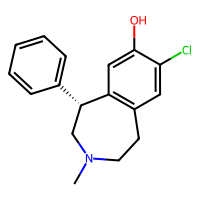
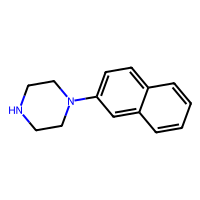
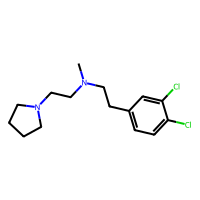
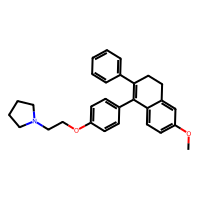
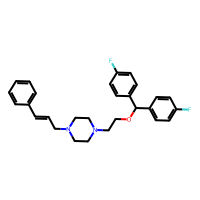
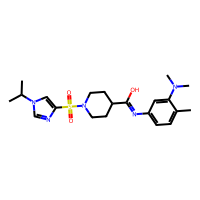
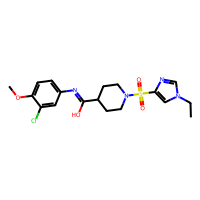
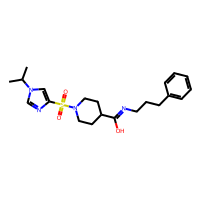
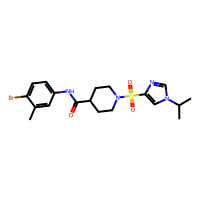
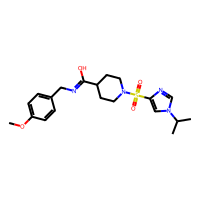

In [23]:
table

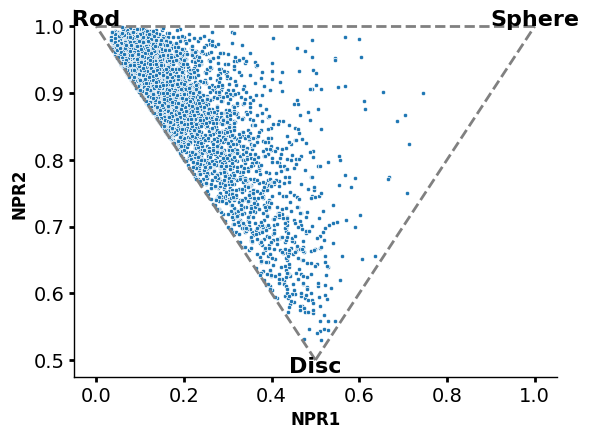

In [24]:
plt.rcParams['axes.linewidth'] = 1.0
plt.figure(figsize=(6,4.5))

ax=sns.scatterplot(x='NPR1',y='NPR2',data=table,s=10,linewidth=0.5,alpha=1)
x1, y1 = [0.5, 0], [0.5, 1]
x2, y2 = [0.5, 1], [0.5, 1]
x3, y3 = [0,1],[1,1]

plt.plot(x1, y1,x2,y2,x3,y3,c='gray',ls='--',lw=2)

plt.xlabel ('NPR1',fontsize=12,fontweight='bold')

plt.ylabel ('NPR2',fontsize=12,fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.text(0, 1.01,s='Rod',fontsize=16,horizontalalignment='center',verticalalignment='center',fontweight='bold')
plt.text(1, 1.01,s='Sphere',fontsize=16,horizontalalignment='center',verticalalignment='center',fontweight='bold')
plt.text(0.5, 0.49,s='Disc',fontsize=16,horizontalalignment='center',verticalalignment='center',fontweight='bold')

plt.tick_params ('both',width=2,labelsize=14)
plt.tight_layout()

plt.show()

In [25]:
# descriptors = table[descriptors_columns].values #The non-redundant molecular descriptors chosen for PCA
descriptors = table[['MolWt', 'LogP','NumHeteroatoms','RingCount','FractionCSP3', 'TPSA','RadiusOfGyration']].values #The non-redundant molecular descriptors chosen for PCA
descriptors_std = StandardScaler().fit_transform(descriptors) #Important to avoid scaling problems between our different descriptors
pca = PCA()
descriptors_2d = pca.fit_transform(descriptors_std)
descriptors_pca= pd.DataFrame(descriptors_2d) # Saving PCA values to a new table
descriptors_pca.index = table.index
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]
descriptors_pca.head(5) #Displays the PCA table

PC1       PC2       PC3       PC4       PC5       PC6       PC7
0 -2.564647 -1.067069  0.768449  0.352883  0.210959 -0.140197  0.246323
1 -3.662295 -0.307113  0.832609  0.863554 -0.598261 -0.395645  0.097073
2 -1.915635 -0.752342  2.796788 -1.223998 -0.317713 -0.475032 -0.171786
3 -0.072253 -3.906906  0.909427  0.558907 -0.029800  0.112294  0.370620
4  0.711295 -3.159649  0.880266 -0.892498 -0.692509 -0.706062  0.298832

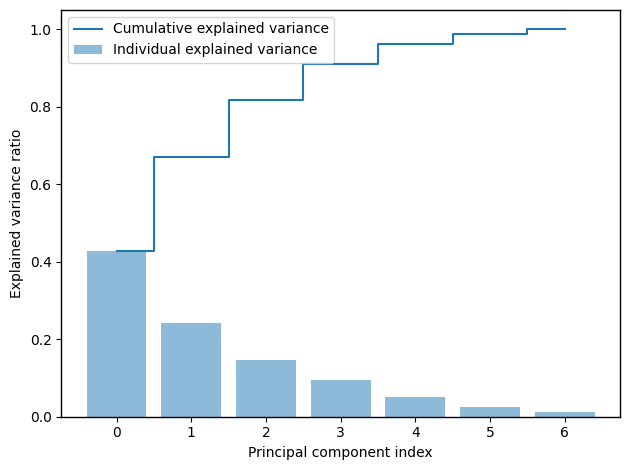

In [33]:
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [27]:
descriptors_pca

PC1       PC2       PC3       PC4       PC5       PC6       PC7
0    -2.564647 -1.067069  0.768449  0.352883  0.210959 -0.140197  0.246323
1    -3.662295 -0.307113  0.832609  0.863554 -0.598261 -0.395645  0.097073
2    -1.915635 -0.752342  2.796788 -1.223998 -0.317713 -0.475032 -0.171786
3    -0.072253 -3.906906  0.909427  0.558907 -0.029800  0.112294  0.370620
4     0.711295 -3.159649  0.880266 -0.892498 -0.692509 -0.706062  0.298832
...        ...       ...       ...       ...       ...       ...       ...
4036  2.003897  0.369379  1.562844 -0.616045  0.141138  0.187329 -0.206467
4037  1.931385  0.806013  0.976263 -0.295685  0.543887 -0.030655 -0.256939
4038  1.403607  0.327172  1.603341 -0.342667  0.242431  0.335105 -0.035452
4039  2.458060  0.024569  1.396673 -1.041063 -0.287128 -0.112811  0.067364
4040  1.932496  0.771908  1.388105 -0.443301 -0.080793  0.200355 -0.190226

[4041 rows x 7 columns]

In [37]:
# This normalization will be performed just for PC1 and PC2, but can be done for all the components.
#The normalization is to plot PCA values in 0-1 sacle and include the vectors (features to the plot)

scale1 = 1.0/(max(descriptors_pca['PC1']) - min(descriptors_pca['PC1'])) 
scale2 = 1.0/(max(descriptors_pca['PC2']) - min(descriptors_pca['PC2']))
scale2 = 1.0/(max(descriptors_pca['PC3']) - min(descriptors_pca['PC3']))

# And we add the new values to our PCA table
descriptors_pca['PC1_normalized']=[i*scale1 for i in descriptors_pca['PC1']]
descriptors_pca['PC2_normalized']=[i*scale2 for i in descriptors_pca['PC2']]
descriptors_pca['PC3_normalized']=[i*scale2 for i in descriptors_pca['PC3']]

C:\Users\lione\AppData\Local\Temp\ipykernel_13872\526750543.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax=sns.scatterplot(x='PC1_normalized',y='PC2_normalized', data=descriptors_pca, s=20, palette=sns.color_palette("Set2", 3),linewidth=0.2,alpha=1)


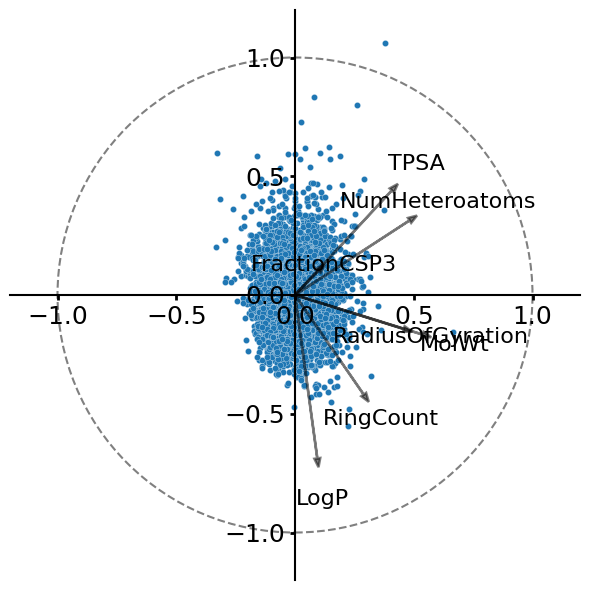

In [39]:
plt.rcParams['axes.linewidth'] = 1.5
plt.figure(figsize=(6,6))

ax=sns.scatterplot(x='PC1_normalized',y='PC2_normalized', data=descriptors_pca, s=20, palette=sns.color_palette("Set2", 3),linewidth=0.2,alpha=1)

plt.xlabel ('',fontsize=20,fontweight='bold')
ax.xaxis.set_label_coords(0.98, 0.45)
plt.ylabel ('',fontsize=20,fontweight='bold')
ax.yaxis.set_label_coords(0.45, 0.98)

ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# lab=descriptors_columns #Feature labels
lab=['MolWt', 'LogP','NumHeteroatoms','RingCount','FractionCSP3', 'TPSA','RadiusOfGyration']

l=np.transpose(pca.components_[0:2, :]) ## We will get the components eigenvectors (main features) for PC1 and PC2

n = l.shape[0]
for i in range(n):
    plt.arrow(0, 0, l[i,0], l[i,1],color= 'k',alpha=0.5,linewidth=1.8,head_width=0.025)
    plt.text(l[i,0]*1.25, l[i,1]*1.25, lab[i], color = 'k',va = 'center', ha = 'center',fontsize=16)

circle = plt.Circle((0,0), 1, color='gray', fill=False,clip_on=True,linewidth=1.5,linestyle='--')

plt.tick_params ('both',width=2,labelsize=18)

ax.add_artist(circle)
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.tight_layout()
plt.savefig("PCA.pdf")

### Distribuciones

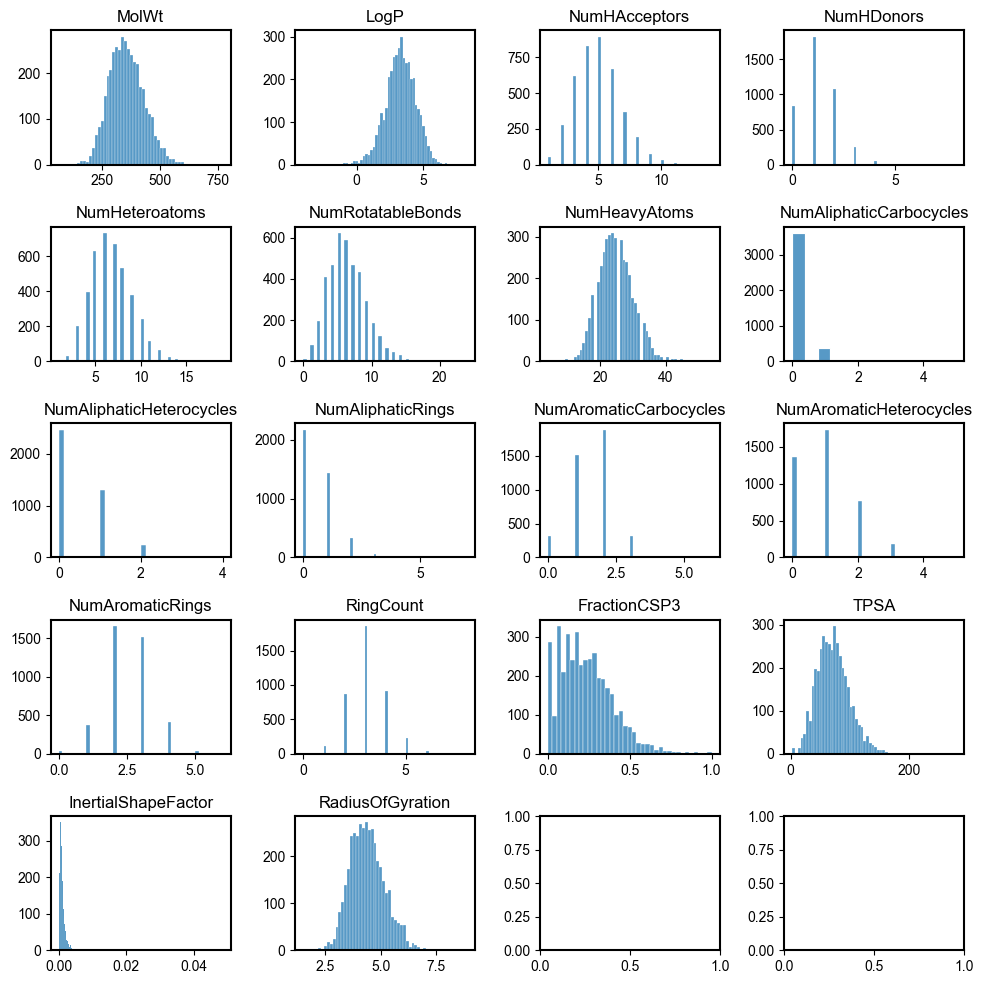

In [42]:
import matplotlib.pyplot as plt
# Define the number of rows and columns you want
n_rows=5
n_cols=4
# Create the subplots
fig, axes = plt.subplots(figsize=(10,10), nrows=n_rows, ncols=n_cols)

sns.set_theme(style="white", palette=None)

for i, column in enumerate(descriptors_columns):
    sns.histplot(table[column],ax=axes[i//n_cols,i%n_cols])

    axes[i//n_cols,i%n_cols].set_title(column, fontsize=12)
    axes[i//n_cols,i%n_cols].set_xlabel(None)
    axes[i//n_cols,i%n_cols].set_ylabel(None)

fig.tight_layout()

### tSNE by Similarity

In [43]:
smiles = table["smiles"]
smi=[Chem.MolFromSmiles(x) for x in smiles]
fps =  [MACCSkeys.GenMACCSKeys(x) for x in smi] # In this example I'll use MACCSKeys
tanimoto_sim_mat_lower_triangle=GetTanimotoSimMat(fps) #This compute a similartity matrix between all the molecules
n_mol = len(fps)
similarity_matrix = np.ones([n_mol,n_mol])
i_lower= np.tril_indices(n=n_mol,m=n_mol,k=-1)
i_upper= np.triu_indices(n=n_mol,m=n_mol,k=1)
similarity_matrix[i_lower] = tanimoto_sim_mat_lower_triangle
similarity_matrix[i_upper] = similarity_matrix.T[i_upper] 
distance_matrix = np.subtract(1,similarity_matrix) #This is the similarity matrix of all vs all molecules in our table
# distance_matrix

In [44]:
def get_silhoute(tsne_result : pd.DataFrame, ax):
    
    range_n_clusters = list(range(2, 50, 1)) # To explore the "best" number of cluster to clasify our molecules
    # range_n_clusters = [8]
    silhouette_scores = []
    # print(range_n_clusters)
    for n_clusters in range_n_clusters:
        # print(n_clusters)
        kmeans = KMeans(n_clusters=n_clusters, random_state=10, n_init=10)
        cluster_labels = kmeans.fit_predict(tsne_result[['TC1','TC2']])
        silhouette_avg = silhouette_score(tsne_result[['TC1','TC1']], cluster_labels)
        silhouette_scores.append((n_clusters, silhouette_avg))

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(tsne_result[['TC1','TC1']], cluster_labels)

    df = pd.DataFrame(silhouette_scores, columns=['n_clusters', 'sil_score'])
    print(list(df['sil_score']))
    sns.lineplot(data=df, x='n_clusters', y='sil_score', ax=ax[1])    
    df_best_n_cluster = df.loc[df[3:]['sil_score'].idxmax()]['n_clusters']
    print(df_best_n_cluster)    
    # best_n_cluster = int(df.iloc[np.argmax(df[3:]['sil_score'])]['n_clusters'])
    best_n_cluster = int(df_best_n_cluster)

    print(f"Best Cluster number: {df.iloc[np.argmax(df[3:]['sil_score'])]}")
    print(f"Best Cluster number: {best_n_cluster}")

    y_lower = 10
    for i in range(best_n_cluster):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / best_n_cluster)
        ax[2].fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax[2].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # The vertical line for average silhouette score of all the values
    ax[2].axvline(x=df.iloc[best_n_cluster]['sil_score'], color="red", linestyle="--")

    ax[2].set_yticks([])  # Clear the yaxis labels / ticks
    ax[2].set_xticks([x/10 for x in range(-10, 10, 2)])

    # Labeling the clusters
    kmeans = KMeans(n_clusters=best_n_cluster, random_state=10, n_init=10)
    cluster_labels = kmeans.fit_predict(tsne_result[['TC1','TC2']])
    centers = kmeans.cluster_centers_

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / best_n_cluster)
    ax[0].scatter(tsne_result['TC1'], tsne_result['TC2'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    # Draw white circles at cluster centers
    ax[0].scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax[0].scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax[0].set_title("Clusters")
    ax[0].set_xlabel("TC1")
    ax[0].set_ylabel("TC2")

    ax[1].set_title("Average Silhoutte Scores")
    ax[1].set_xlabel("# Clusters")
    ax[1].set_ylabel("Silhoutte Average Score")    

    ax[2].set_title("Silhouttes")
    ax[2].set_xlabel("# Clusters")
    ax[2].set_ylabel("Silhoutte Average Score")        

    

Performing tSNE for p=2
Performing silhoutte analysis for p=2
[0.08328461647033691, 0.1710692197084427, 0.14062285423278809, 0.0002824704861268401, 0.0014932387275621295, -0.01955338381230831, -0.06814774125814438, -0.09831466525793076, -0.09336096793413162, -0.07362952828407288, -0.12054125219583511, -0.0996178612112999, -0.13608042895793915, -0.13546808063983917, -0.1294388622045517, -0.1302909553050995, -0.1398063749074936, -0.13347657024860382, -0.13560855388641357, -0.15202590823173523, -0.15530207753181458, -0.16191287338733673, -0.17818909883499146, -0.16854031383991241, -0.17076213657855988, -0.17661665380001068, -0.17339454591274261, -0.18169263005256653, -0.18530535697937012, -0.17143574357032776, -0.18747958540916443, -0.18270061910152435, -0.19927914440631866, -0.19313213229179382, -0.1787511706352234, -0.18703056871891022, -0.20031964778900146, -0.19339212775230408, -0.19961009919643402, -0.19124263525009155, -0.19790488481521606, -0.19763895869255066, -0.2056533396244049,

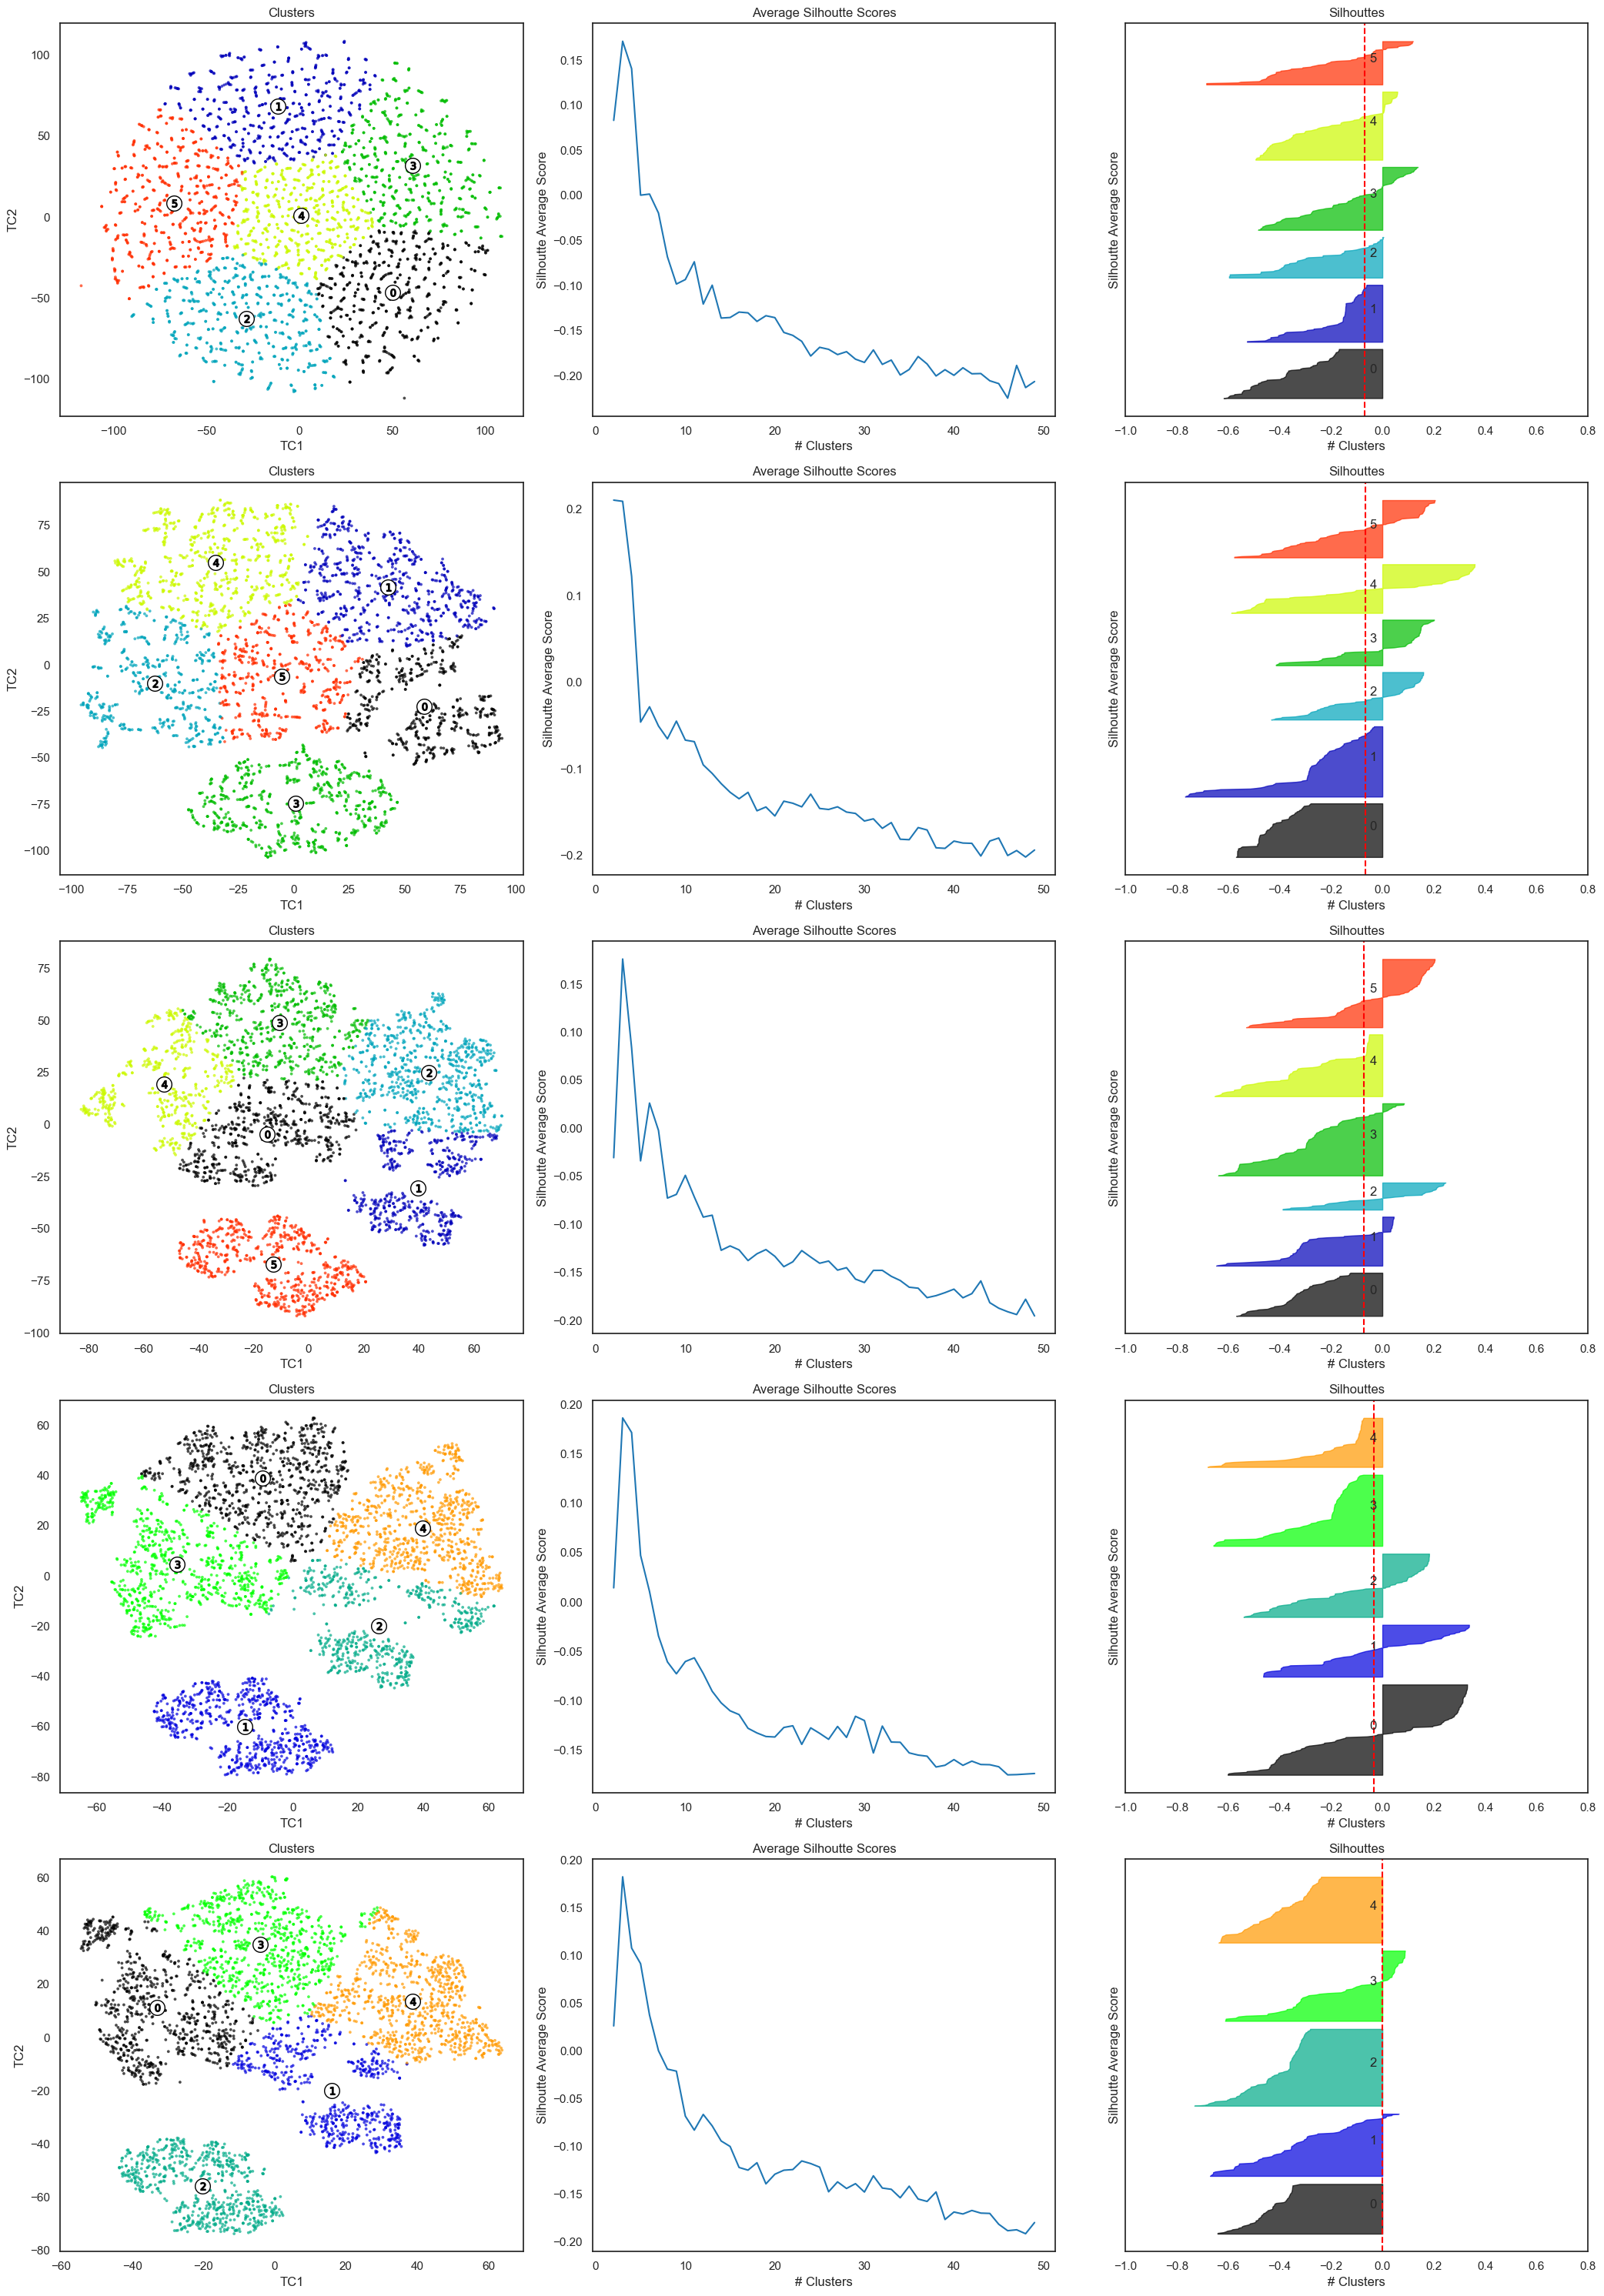

In [45]:
perplexity_scan = [2, 10, 25, 40, 50]
n_iter = 1000

fig, axs = plt.subplots(figsize=(21,30), nrows=5, ncols=3)

for _, perplexity in enumerate(perplexity_scan):

    axrow = axs[_ % 6]

    print(f"Performing tSNE for p={perplexity}")
    TSNE_sim = TSNE(n_components=2, init='random', random_state=90, angle = 0.3, perplexity=perplexity, n_iter=n_iter).fit_transform(distance_matrix) #Remember to always tune the parameters acording your dataset!!
    tsne_result = pd.DataFrame(data = TSNE_sim , columns=["TC1","TC2"]) # New table containing the tSNE results
    print(f"Performing silhoutte analysis for p={perplexity}")
    silhouette_samples_df = get_silhoute(tsne_result, axrow)

    plt.rcParams['axes.linewidth'] = 1.0

plt.tight_layout()
plt.savefig("tsne-kmeans-exploration.pdf")


### tSNE + K-means

In [52]:
# TSNE
TSNE_sim = TSNE(n_components=2, init='random', random_state=90, angle = 0.3, perplexity=50, n_iter=1000).fit_transform(distance_matrix) #Remember to always tune the parameters acording your dataset!!
tsne_result = pd.DataFrame(data = TSNE_sim , columns=["TC1","TC2"]) # New table containing the tSNE results

kmeans = KMeans(n_clusters=5, random_state=10) # We define the best number of clusters (6)
clusters = kmeans.fit(tsne_result[['TC1','TC2']]) #TC1vs TC2

tsne_result['Cluster'] = pd.Series(clusters.labels_, index=tsne_result.index)
tsne_result['mol_id'] = table['mol_id'].astype(int)

### Hierarchichal

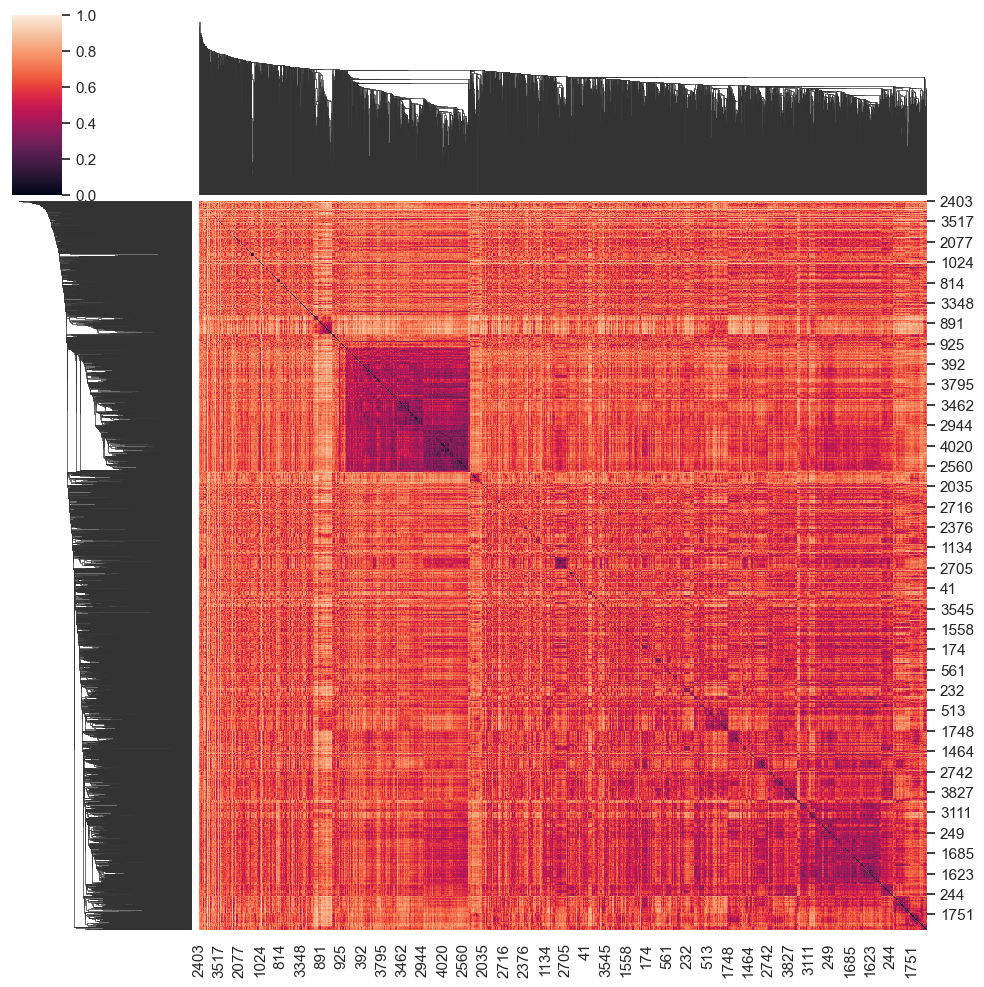

In [125]:
import numpy as np
import pandas as pd
from rdkit import Chem
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

library = ndpi_available_cherry.copy()
# library["fps"] = library.apply(lambda x: Chem.Fingerprints.FingerprintMols.FingerprintMol(x["mol"]), axis=1)

size=len(library)
hmap=np.empty(shape=(size,size))

hmapx = np.array(distance_matrix)
linked = linkage(distance_matrix, method='single')
labelList = ndpi_available_cherry["mol_id"]

sns.clustermap(distance_matrix, method='single')



In [126]:
def get_tanimoto_index_matrix(molecules):
    fps = [MACCSkeys.GenMACCSKeys(x) for x in molecules] 
    tanimoto_sim_mat_lower_triangle=GetTanimotoSimMat(fps) 
    # n_mol = len(fps)
    # similarity_matrix = np.ones([n_mol,n_mol])
    # i_lower= np.tril_indices(n=n_mol,m=n_mol,k=-1)
    # i_upper= np.triu_indices(n=n_mol,m=n_mol,k=1)
    # similarity_matrix[i_lower] = tanimoto_sim_mat_lower_triangle
    # similarity_matrix[i_upper] = similarity_matrix.T[i_upper] 
    # distance_matrix = np.subtract(1, similarity_matrix) #This is the similarity matrix of all vs all molecules in our table
    return tanimoto_sim_mat_lower_triangle.flatten()

In [127]:
thresholds = [x/10 for x in range(8, 40, 8)]

microcluster_screen_df = pd.DataFrame()
value_counts_per_t = []

for i, t in enumerate(thresholds):
    
    clusters = fcluster(linked, t, criterion="distance")
    molclusters = pd.DataFrame({'mol_id': labelList, 'cluster': clusters })
    clusters_agg = molclusters['cluster'].value_counts(ascending=False)



    microcluster_screen_df.loc[i,'threshold'] = t
    microcluster_screen_df.loc[i,'max_cluster_size'] = clusters_agg.max()
    microcluster_screen_df.loc[i,'min_cluster_size'] = clusters_agg.min()
    microcluster_screen_df.loc[i,'mean_cluster_size'] = clusters_agg.mean()
    microcluster_screen_df.loc[i,'median_cluster_size'] = clusters_agg.median()
    # microcluster_screen_df.loc[i,'top_10_biggest_clusters'] = ", ".join(clusters_agg.index[:10].astype(str).tolist())
    microcluster_screen_df.loc[i,'number_of_clusters'] = len(set(clusters_agg.reset_index()['cluster']))
    #microcluster_screen_df.loc[i,'number_of_clusters_non_unitary'] = len(set(clusters_agg[clusters_agg.reset_index()['count']].reset_index()['cluster']))

    clusters_agg_df = clusters_agg.to_frame()

    microcluster_screen_df.loc[i,'number_of_clusters_non_unitary'] = len(clusters_agg_df[clusters_agg_df['count']>1].index)

    clusters_agg_df['t'] = str(t)
    
    value_counts_per_t.append(clusters_agg_df)

microcluster_screen_df

#ndpi_available_cherry_wclusters = pd.merge(library, molclusters,on="mol_id")

# ndpi_available_cherry_wclusters

threshold  max_cluster_size  min_cluster_size  mean_cluster_size  \
0        0.8               5.0               1.0           1.040422   
1        1.6               9.0               1.0           1.127826   
2        2.4             231.0               1.0           1.650735   
3        3.2            2447.0               1.0           8.114458   

   median_cluster_size  number_of_clusters  number_of_clusters_non_unitary  
0                  1.0              3884.0                           130.0  
1                  1.0              3583.0                           325.0  
2                  1.0              2448.0                           536.0  
3                  1.0               498.0                           115.0

In [128]:
cluster_sizes = pd.concat(value_counts_per_t,axis=0)
cluster_sizes = cluster_sizes.reset_index()
cluster_sizes[cluster_sizes['count']>5]

cluster  count    t
3884     2948      9  1.6
3885      397      8  1.6
3886      818      8  1.6
3887      134      7  1.6
3888      807      7  1.6
...       ...    ...  ...
9922      144     10  3.2
9923      182      9  3.2
9924      124      9  3.2
9925      205      9  3.2
9926      111      7  3.2

[81 rows x 3 columns]

In [129]:
# t=0.8
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)


In [130]:
clusters = fcluster(linked, 0.8, criterion="distance")
molclusters = pd.DataFrame({'mol_id': labelList, 'cluster': clusters })
ndpi_available_cherry_wclusters = pd.merge(library, molclusters, on="mol_id")
print(clusters)
mean_tanimoto_indexes_08 = []
for cluster in cluster_sizes[cluster_sizes['t']=='0.8'][cluster_sizes['count']>1].cluster.values:
    mols = [mol for mol in ndpi_available_cherry_wclusters[ndpi_available_cherry_wclusters['cluster']==cluster].mol]
    # print(f'Mean Tanimoto Distance index between molecules: {get_tanimoto_index_matrix(mols).mean():.4f}')
    mean_tanimoto_indexes_08.append(get_tanimoto_index_matrix(mols).mean())

mean_tanimoto_indexes = pd.DataFrame(mean_tanimoto_indexes_08, columns=['t=0.8'])


[2490 2644 3329 ...  919  925  903]


In [61]:
# clusters = fcluster(linked, 1.6, criterion="distance")
# molclusters = pd.DataFrame({'mol_id': labelList, 'cluster': clusters })
# ndpi_available_cherry_wclusters = pd.merge(library, molclusters, on="mol_id")
# mean_tanimoto_indexes_16 = []
# for cluster in cluster_sizes[cluster_sizes['t']=='1.6'][cluster_sizes['count']>1].cluster.values:
#     mols = [mol for mol in ndpi_available_cherry_wclusters[ndpi_available_cherry_wclusters['cluster']==cluster].mol]
#     # print(f'Mean Tanimoto Distance index between molecules: {get_tanimoto_index_matrix(mols).mean():.4f}')
#     mean_tanimoto_indexes_16.append(get_tanimoto_index_matrix(mols).mean())

# mean_tanimoto_indexes = pd.DataFrame(mean_tanimoto_indexes_16, columns=['t=1.6']).combine_first(mean_tanimoto_indexes)

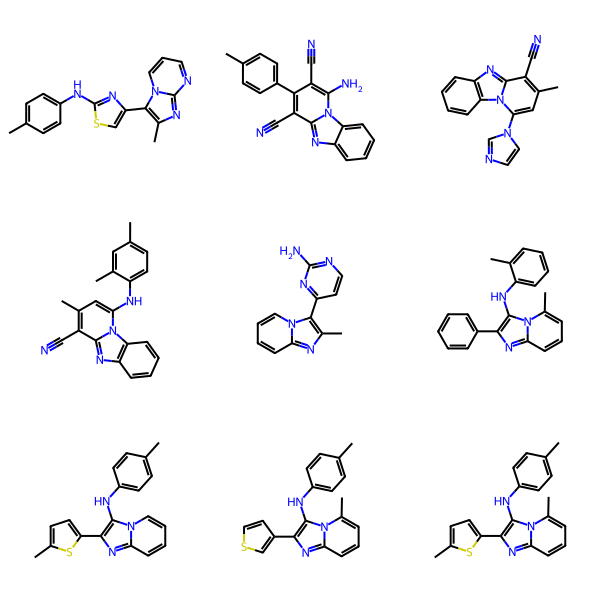

In [62]:
# # t=1.6
# mols = [mol for mol in ndpi_available_cherry_wclusters[ndpi_available_cherry_wclusters['cluster']==2948].mol]
# for m in mols:
#     rdDepictor.Compute2DCoords(m)
# Draw.MolsToGridImage(mols, molsPerRow=3)
# #print(f'Mean Tanimoto Distance index between molecules: {get_tanimoto_index_matrix(mols).mean():.4f}')

In [63]:
# clusters = fcluster(linked, 2.4, criterion="distance")
# molclusters = pd.DataFrame({'mol_id': labelList, 'cluster': clusters })
# ndpi_available_cherry_wclusters = pd.merge(library, molclusters, on="mol_id")
# mean_tanimoto_indexes_24 = []
# for cluster in cluster_sizes[cluster_sizes['t']=='2.4'][cluster_sizes['count']>1].cluster.values:
#     mols = [mol for mol in ndpi_available_cherry_wclusters[ndpi_available_cherry_wclusters['cluster']==cluster].mol]
#     # print(f'Mean Tanimoto Distance index between molecules: {get_tanimoto_index_matrix(mols).mean():.4f}')
#     mean_tanimoto_indexes_24.append(get_tanimoto_index_matrix(mols).mean())

# mean_tanimoto_indexes = pd.DataFrame(mean_tanimoto_indexes_24, columns=['t=2.4']).combine_first(mean_tanimoto_indexes)

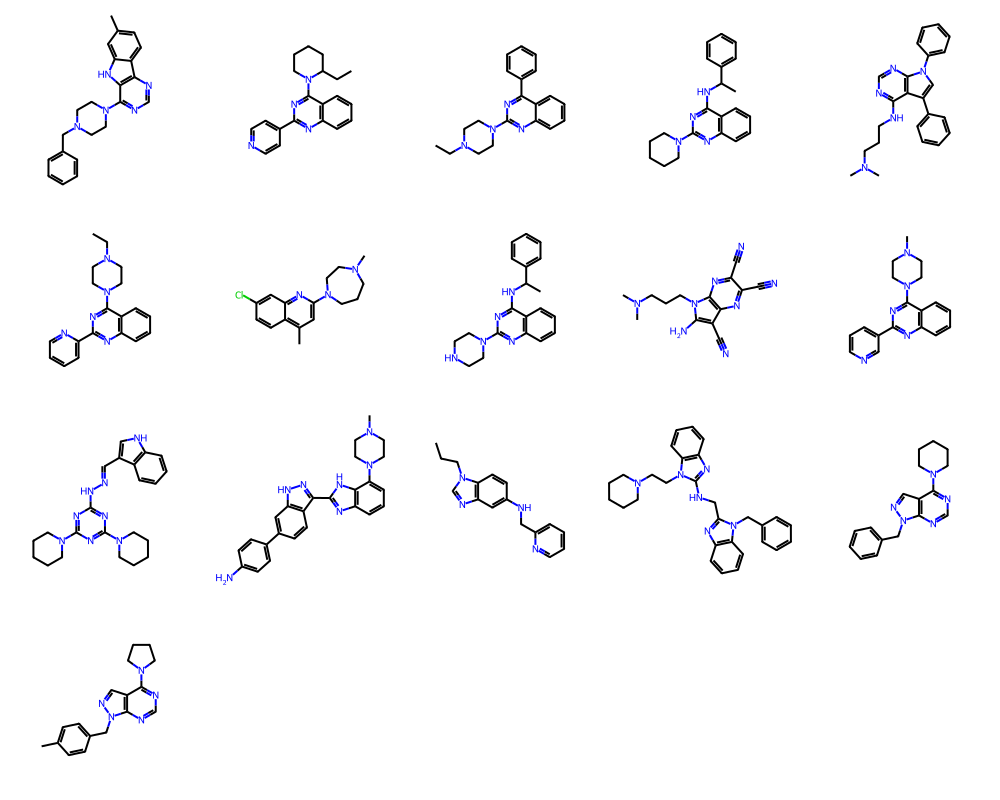

In [64]:
# # t=2.4
# clusters = fcluster(linked, 2.4, criterion="distance")
# molclusters = pd.DataFrame({'mol_id': labelList, 'cluster': clusters })
# ndpi_available_cherry_wclusters = pd.merge(library, molclusters, on="mol_id")
# mols = [mol for mol in ndpi_available_cherry_wclusters[ndpi_available_cherry_wclusters['cluster']==1849].mol]
# for m in mols:
#     rdDepictor.Compute2DCoords(m)
# Draw.MolsToGridImage(mols, molsPerRow=5)
# #print(f'Mean Tanimoto Distance index between molecules: {get_tanimoto_index_matrix(mols).mean():.4f}')

In [77]:
# clusters = fcluster(linked, 3.2, criterion="distance")
# molclusters = pd.DataFrame({'mol_id': labelList, 'cluster': clusters })
# ndpi_available_cherry_wclusters = pd.merge(library, molclusters, on="mol_id")
# mean_tanimoto_indexes_32 = []
# for cluster in cluster_sizes[cluster_sizes['t']=='3.2'][cluster_sizes['count']>1].cluster.values:
#     mols = [mol for mol in ndpi_available_cherry_wclusters[ndpi_available_cherry_wclusters['cluster']==cluster].mol]
#     # print(f'Mean Tanimoto Distance index between molecules: {get_tanimoto_index_matrix(mols).mean():.4f}')
#     mean_tanimoto_indexes_32.append(get_tanimoto_index_matrix(mols).mean())

# mean_tanimoto_indexes = pd.DataFrame(mean_tanimoto_indexes_32, columns=['t=3.2']).combine_first(mean_tanimoto_indexes)

In [132]:
# fig = plt.figure(figsize=(9.5,15))
# plt.tick_params(axis='both', which='major', labelsize=18)

# for spine in [0.2,0.4,0.6,0.8,1.0]:
#     plt.axvline(x=spine, color='grey', linestyle="--")

# ax = sns.violinplot(data=mean_tanimoto_indexes, orient='h')

# ax.set_title('Mean Tanimoto index between cluster members',fontsize=18)
# #ax.set_xlabel('t values', fontsize=16)
# #ax.set_ylabel('Tanimoto index', fontsize=16)

In [133]:
clusters_count = ndpi_available_cherry_wclusters.groupby(['cluster'])["mol_id"].agg(['count'])
clusters_count = clusters_count.reset_index()
clusters_count = clusters_count[clusters_count["count"]<10]
# microclusters = ndpi_available_cherry_wclusters[ndpi_available_cherry_wclusters["cluster"].isin(clusters_count[clusters_count['count']>1]["cluster"])].reset_index(drop=True)


cluster  count  mol_id                                    smiles  \
0        1      1  574926                              CC1CCC(CC1)N   
1        2      1  543925                                 OCC[NH3+]   
2        3      1  248503   Cc1ccc(cc1)C(=O)N1CCCC(=N1)c1ccc(cc1)Cl   
3        4      1  248505  Clc1ccc(cc1)C1=NN(CCC1)C(=O)c1cccc(c1)Cl   
4        5      1  634318    O/N=C/c1cn(nc1c1ccc(cc1)c1ccccc1)CCC#N   

      known_target                          known_target_product  \
0    PF3D7_1129000                           spermidine synthase   
1    PF3D7_1246100          delta-aminolevulinic acid synthetase   
2  ENSG00000138413  isocitrate dehydrogenase 1 (NADP+), soluble    
3  ENSG00000138413  isocitrate dehydrogenase 1 (NADP+), soluble    
4  ENSG00000138413  isocitrate dehydrogenase 1 (NADP+), soluble    

  known_target_species         gene_name        omcl  nds_tier  \
0                  pfa   TcCLB.510339.50  OG5_127074         4   
1                  pfa   TcCLB.511899.40  OG5_126783         4   
2                  hsa  TcCLB.506925.319  OG5_127057         3   
3                  hsa  TcCLB.506925.319  OG5_127057         3   
4                  hsa  TcCLB.506925.319  OG5_127057         3   

                                      gene_product_x  \
0                      spermidine synthase, putative   
1  2-amino-3-ketobutyrate coenzyme A ligase, puta...   
2                 isocitrate dehydrogenase, putative   
3                 isocitrate dehydrogenase, putative   
4                 isocitrate dehydrogenase, putative   

                                                 mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x000002CAA14...   
1  <rdkit.Chem.rdchem.Mol object at 0x000002CAA14...   
2  <rdkit.Chem.rdchem.Mol object at 0x000002CA9DD...   
3  <rdkit.Chem.rdchem.Mol object at 0x000002CA9DD...   
4  <rdkit.Chem.rdchem.Mol object at 0x000002CA9DD...   

                                               inchi  \
0  InChI=1S/C7H15N/c1-6-2-4-7(8)5-3-6/h6-7H,2-5,8...   
1             InChI=1S/C2H7NO/c3-1-2-4/h4H,1-3H2/p+1   
2  InChI=1S/C18H17ClN2O/c1-13-4-6-15(7-5-13)18(22...   
3  InChI=1S/C17H14Cl2N2O/c18-14-8-6-12(7-9-14)16-...   
4  InChI=1S/C19H16N4O/c20-11-4-12-23-14-18(13-21-...   

                      inchikey  \
0  KSMVBYPXNKCPAJ-UHFFFAOYSA-N   
1  HZAXFHJVJLSVMW-UHFFFAOYSA-O   
2  KTEOADIHRLJFPR-UHFFFAOYSA-N   
3  GRJNABPGYLAGPR-UHFFFAOYSA-N   
4  CFDUAHOCHWNHJY-FYJGNVAPSA-N   

                                                Link provider  \
0  https://www.molport.com/shop/molecule-link/Mol...  molport   
1  https://www.molport.com/shop/molecule-link/Mol...  molport   
2  https://www.molport.com/shop/molecule-link/Mol...  molport   
3  https://www.molport.com/shop/molecule-link/Mol...  molport   
4  https://www.molport.com/shop/molecule-link/Mol...  molport   

                                      gene_product_y  
0                      spermidine synthase, putative  
1  2-amino-3-ketobutyrate coenzyme A ligase, puta...  
2                 isocitrate dehydrogenase, putative  
3                 isocitrate dehydrogenase, putative  
4                 isocitrate dehydrogenase, putative
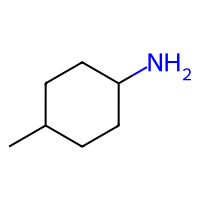
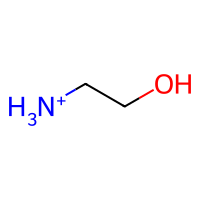
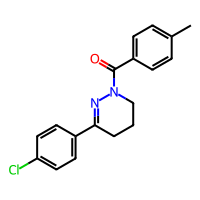
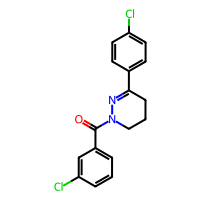
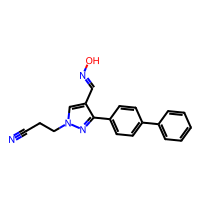

In [134]:
# Remove big, sparse clusters
ndpi_available_cherry_wclusters = ndpi_available_cherry_wclusters[ndpi_available_cherry_wclusters["cluster"].isin(clusters_count["cluster"])].reset_index(drop=True)
ndpi_available_cherry_wclusters_count = clusters_count.merge(ndpi_available_cherry_wclusters, how="outer", on="cluster")
ndpi_available_cherry_wclusters_count.head()
# ndpi_available_cherry_wclusters

[(0.0, 15.0)]

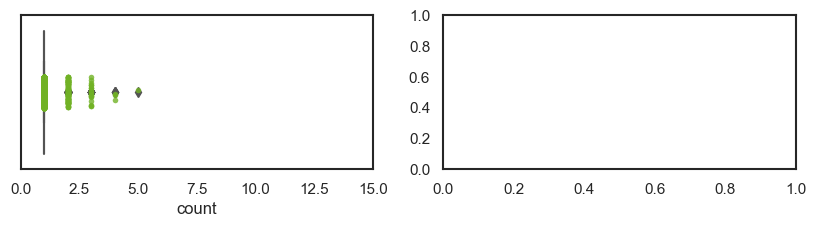

In [135]:
ndpi_available_cherry_wclusters = ndpi_available_cherry_wclusters_count.groupby(['cluster'])["mol_id"].agg(['count'])
ndpi_available_cherry_wclusters_min = ndpi_available_cherry_wclusters_count[ndpi_available_cherry_wclusters_count["count"]<5]


fig, axs = plt.subplots(1,2,figsize=(10,2))
g = sns.stripplot(data=ndpi_available_cherry_wclusters, x='count', ax=axs[0], size=4, color="#71b225", linewidth=0, alpha=0.8)
g = sns.boxplot(data=ndpi_available_cherry_wclusters, x='count', ax=axs[0], color="#f38a22")
g.set(xlim=(0,15))


#g2 = sns.boxplot(data=mds, x='cluster', ax=axs[1])
#g2.set(xlim=(60,3000))

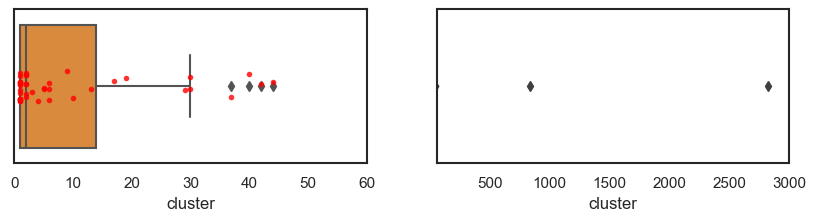

In [136]:
mds_check = ndpi_available_cherry_wclusters_count.copy()
mds = mds_check.groupby(['gene_name'],as_index=False).agg({'cluster': 'count'})

fig, axs = plt.subplots(1,2,figsize=(10,2))
g = sns.stripplot(data=mds, x='cluster', ax=axs[0], size=4, color="red", linewidth=0, alpha=0.8)
g = sns.boxplot(data=mds, x='cluster', ax=axs[0], color="#f38a22")
g.set(xlim=(0,60))


g2 = sns.boxplot(data=mds, x='cluster', ax=axs[1])
g2.set(xlim=(60,3000))


# threshold = (np.percentile(mds["cluster"], 80))
# plt.axvline(threshold,color="red",linestyle="--")
# plt.xlim((0, 50))   # set the xlim to left, right

plt.savefig("outliers.pdf")



cluster  count   mol_id  \
0           1      1   574926   
1           2      1   543925   
7           8      1  2238376   
28         29      1   214217   
36         36      3  1619933   
...       ...    ...      ...   
4003     3847      1  2117990   
4008     3852      1   530996   
4013     3857      1  1294875   
4016     3860      1    28930   
4036     3880      1  2151532   

                                                 smiles     known_target  \
0                                          CC1CCC(CC1)N    PF3D7_1129000   
1                                             OCC[NH3+]    PF3D7_1246100   
7                                        C=CCOCc1ccccc1           Rv2215   
28                                     C1CCc2c(C1)cncc2  ENSG00000147955   
36         CC1=C(C)C(=O)C=C/C/1=N/OS(=O)(=O)c1ccc(cc1)C  ENSG00000178802   
...                                                 ...              ...   
4003  Clc1nccc(c1)Nc1nccc(n1)c1cnc(nc1CC1CC1)NCC(O)(C)C             5289   
4008         CCCCCCCCN[C@@H]([C@H](c1ccc(cc1)SC(C)C)O)C  ENSG00000147955   
4013                          O=C(Nc1n[nH]cn1)CCC1CCCC1  ENSG00000111640   
4016                           OC(=O)c1cc2c([nH]1)cccc2             6716   
4036                                          CNCCN(C)C  ENSG00000111218   

                                   known_target_product known_target_species  \
0                                   spermidine synthase                  pfa   
1                  delta-aminolevulinic acid synthetase                  pfa   
7     DlaT, dihydrolipoamide acyltransferase, E2 com...                  mtu   
28            sigma non-opioid intracellular receptor 1                  hsa   
36                         mannose phosphate isomerase                   hsa   
...                                                 ...                  ...   
4003  phosphatidylinositol 3-kinase, catalytic subun...                  hsa   
4008          sigma non-opioid intracellular receptor 1                  hsa   
4013          glyceraldehyde-3-phosphate dehydrogenase                   hsa   
4016  steroid-5-alpha-reductase, alpha polypeptide 2...                  hsa   
4036              protein arginine methyltransferase 8                   hsa   

             gene_name        omcl  nds_tier  \
0      TcCLB.510339.50  OG5_127074         4   
1      TcCLB.511899.40  OG5_126783         4   
7      TcCLB.506025.60  OG5_127362         3   
28     TcCLB.510329.90  OG5_131051         5   
36     TcCLB.511717.90  OG5_127555         5   
...                ...         ...       ...   
4003  TcCLB.511903.160  OG5_128181         5   
4008   TcCLB.510329.90  OG5_131051         5   
4013   TcCLB.506943.50  OG5_126628         4   
4016   TcCLB.504427.70  OG5_128852         4   
4036  TcCLB.508593.110  OG5_127422         4   

                                         gene_product_x  \
0                         spermidine synthase, putative   
1     2-amino-3-ketobutyrate coenzyme A ligase, puta...   
7     2-oxoglutarate dehydrogenase, E2 component, di...   
28                       C-8 sterol isomerase, putative   
36                   phosphomannose isomerase, putative   
...                                                 ...   
4003           phosphatidylinositol 3-kinase vps34-like   
4008                     C-8 sterol isomerase, putative   
4013  glyceraldehyde 3-phosphate dehydrogenase, puta...   
4016    3-oxo-5-alpha-steroid 4-dehydrogenase, putative   
4036             arginine N-methyltransferase, putative   

                                                    mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x000002CAA14...   
1     <rdkit.Chem.rdchem.Mol object at 0x000002CAA14...   
7     <rdkit.Chem.rdchem.Mol object at 0x000002CAA13...   
28    <rdkit.Chem.rdchem.Mol object at 0x000002CA9DB...   
36    <rdkit.Chem.rdchem.Mol object at 0x000002CAA13...   
...                                                 ...   
4003  <rdkit.Chem.rdchem.Mol object 
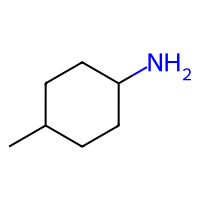
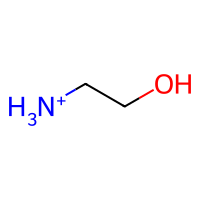
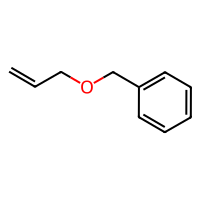
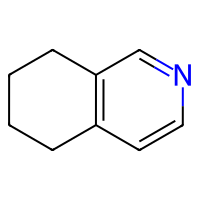
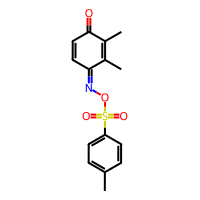
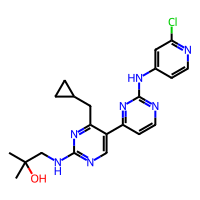
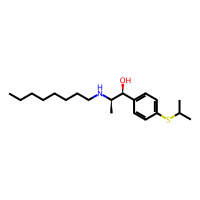
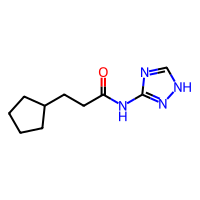
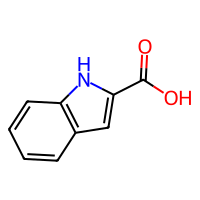
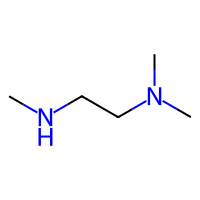

In [137]:
mds_genes = mds[mds["cluster"] < 50]["gene_name"]
library_min = ndpi_available_cherry_wclusters_min[ndpi_available_cherry_wclusters_min["gene_name"].isin( mds_genes)]
library_min

In [138]:
library_min = library_min[['mol_id', 'smiles','known_target', 'known_target_product',
       'known_target_species', 'gene_name',
        'mol', 'inchi', 'inchikey', 'Link', 'provider', 'cluster',
        'count']]
library_min = pd.merge(library_min,tcr_targets_full,how="inner",on="gene_name")
library_min.mol_id.unique

<bound method Series.unique of 0       574926
1       543925
2      2238376
3        73172
4      2151924
        ...   
375    2103102
376     222616
377    1186521
378    1537252
379    1325593
Name: mol_id, Length: 380, dtype: int64>

## Library Assembly

In [139]:
library_min["mol"] = library_min.apply(lambda x : Chem.MolFromSmiles(x["smiles"]),axis=1)        

In [140]:
from rdkit.Chem import Draw

m = []

for i, mol in library_min.iterrows() :    

    m.append(Draw.MolToImage(mol["mol"], size=(300, 300)))
        
library_min["mol_thumb"] = m

In [141]:
def matchesSubstructure(mols : list , scaffolds : list) :     
    matches = []
    for mol in mols :
        for scaffold in scaffolds :         
            matches = mol.GetSubstructMatches(safe_molFromSmiles(scaffold))
            if len(matches) > 0 :
                return True
    
    return False

mol_id                                             smiles  \
0     574926                                       CC1CCC(CC1)N   
1     543925                                          OCC[NH3+]   
2    2238376                                     C=CCOCc1ccccc1   
3      73172           O=C1C(=O)c2ccccc2c2c1cc(cc2)[N+](=O)[O-]   
4    2151924     C=CCn1c2nc3ccccc3nc2c(c1NS(=O)(=O)c1ccccc1)C#N   
..       ...                                                ...   
375  2103102  CCNC(=O)NCCSC[C@H]1O[C@H]([C@@H]([C@@H]1O)O)n1...   
376   222616                             Oc1ccc(cc1)C(=O)C(=O)O   
377  1186521  CCCCCCCCCCCCCCNC(=O)N[C@@H](C[N+](C)(C)C)CC(=O...   
378  1537252  O=C(n1ncc(n1)C(c1ccccc1)(c1ccccc1)O)N1CCC(CC1)...   
379  1325593                       Clc1ccc2c(c1)onc2OC(=O)N(C)C   

           known_target                               known_target_product  \
0         PF3D7_1129000                                spermidine synthase   
1         PF3D7_1246100               delta-aminolevulinic acid synthetase   
2                Rv2215  DlaT, dihydrolipoamide acyltransferase, E2 com...   
3                Rv2215  DlaT, dihydrolipoamide acyltransferase, E2 com...   
4                Rv2215  DlaT, dihydrolipoamide acyltransferase, E2 com...   
..                  ...                                                ...   
375     ENSG00000100462              protein arginine methyltransferase 5    
376     ENSG00000205560        carnitine palmitoyltransferase 1B (muscle)    
377     ENSG00000205560        carnitine palmitoyltransferase 1B (muscle)    
378     ENSG00000011009                              lysophospholipase II    
379  ENSMUSG00000023913  phospholipase A2, group VII (platelet-activati...   

    known_target_species         gene_name  \
0                    pfa   TcCLB.510339.50   
1                    pfa   TcCLB.511899.40   
2                    mtu   TcCLB.506025.60   
3                    mtu   TcCLB.506025.60   
4                    mtu   TcCLB.506025.60   
..                   ...               ...   
375                  hsa   TcCLB.506853.30   
376                  hsa   TcCLB.507211.10   
377                  hsa   TcCLB.507211.10   
378                  hsa   TcCLB.511907.50   
379                  mmu  TcCLB.510659.250   

                                                   mol  \
0    <rdkit.Chem.rdchem.Mol object at 0x000002CBC8A...   
1    <rdkit.Chem.rdchem.Mol object at 0x000002CBC8A...   
2    <rdkit.Chem.rdchem.Mol object at 0x000002CBC8A...   
3    <rdkit.Chem.rdchem.Mol object at 0x000002CBC8A...   
4    <rdkit.Chem.rdchem.Mol object at 0x000002CBC8A...   
..                                                 ...   
375  <rdkit.Chem.rdchem.Mol object at 0x000002CBC8A...   
376  <rdkit.Chem.rdchem.Mol object at 0x000002CBC8A...   
377  <rdkit.Chem.rdchem.Mol object at 0x000002CBC8A...   
378  <rdkit.Chem.rdchem.Mol object at 0x000002CBC8A...   
379  <rdkit.Chem.rdchem.Mol object at 0x000002CBC8A...   

                                                 inchi  \
0    InChI=1S/C7H15N/c1-6-2-4-7(8)5-3-6/h6-7H,2-5,8...   
1               InChI=1S/C2H7NO/c3-1-2-4/h4H,1-3H2/p+1   
2    InChI=1S/C10H12O/c1-2-8-11-9-10-6-4-3-5-7-10/h...   
3    InChI=1S/C14H7NO4/c16-13-11-4-2-1-3-9(11)10-6-...   
4    InChI=1S/C20H15N5O2S/c1-2-12-25-19(24-28(26,27...   
..                                                 ...   
375  InChI=1S/C15H23N7O4S/c1-2-17-15(25)18-3-4-27-5...   
376  InChI=1S/C8H6O4/c9-6-3-1-5(2-4-6)7(10)8(11)12/...   
377  InChI=1S/C22H45N3O3/c1-5-6-7-8-9-10-11-12-13-1...   
378  InChI=1S/C25H30N4O2/c1-24(2,3)19-14-16-28(17-1...   
379  InChI=1S/C10H9ClN2O3/c1-13(2)10(14)15-9-7-4-3-...   

                        inchikey  \
0    KSMVBYPXNKCPAJ-UHFFFAOYSA-N   
1    HZAXFHJVJLSVMW-UHFFFAOYSA-O   
2    HUGHWHMUUQNACD-UHFFFAOYSA-N   
3    KNAXWOBOCVVMST-UHFFFAOYSA-N   
4    FESFSIJRTMDEFH-UHFFFAOYSA-N   
..                           ...   
375  CACMCLIHCDTJHL-IDTAVKCVSA-N   
376  KXFJZKUFXHWWAJ-UHFFFAOYS
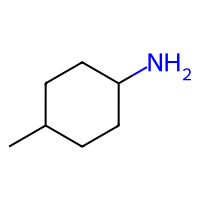
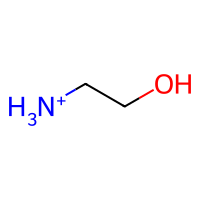
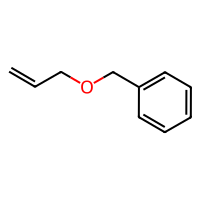
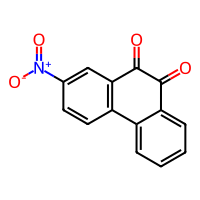
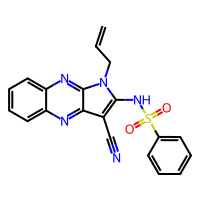
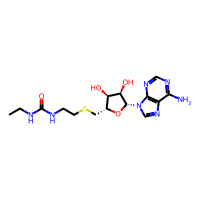
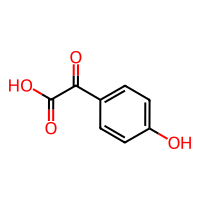
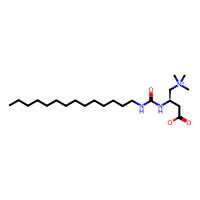
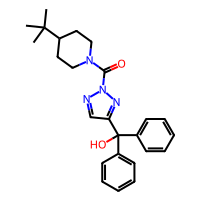
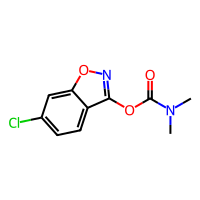

In [142]:
library= library_min.copy()
library

In [143]:
scaffolds = {
    'benzamidine' : ['NC(=O)C1=CC=CC=C1'],
    'sulfonamide' : ['NS(=O)(=O)C1=CC=CC=C1'],
    'picolinamide' : ['NC(=O)C1=CC=CC=N1'],
    'indole' : ['N1C=CC2=C1C=CC=C2'],
    'piperazine' : ['C1CNCCN1'],
    'morpholine' : ['C1COCCN1'],
    'azole' : ['N1C=CC=C1','N1C=CN=N1','C1N=CC=N1','N1C=CN=C1','N1C=NC=N1'],
    'pirrolone' : ['O=C1NCC=C1'],
    'thiazole' : ['S1C=CN=C1','S1C=CC=C1'],
    'oxazole' : ['O1C=CN=C1','O1C=CC=C1'],
    'furan' : ['O1C=CC=C1'],
    'napthalene_diimide' : ["O=C1NC(=O)C2=C3C(C=CC=C13)=CC=C2"],
    'chromenes' : ["C1C=COC2=C1C=CC=C2","O=C1C=COC2=C1C=CC=C2"],
    'benzothiazole' : ["S1C=NC2=C1C=CC=C2"],
    'thiazoleidine' : ["O=C1CSC(=S)N1"],
    'waltherione' : ['COC1=CC=CC2=C1NCCC2=O'],
    'adenine' : ['NC1=NC=NC2=C1NC=N2'],    
    'nitro' : ['O=N(=O)C1=CC=CC=C1']
}

In [144]:
collections = []

for scaffold_id, scaffold_mol in scaffolds.items() : 
    
    scaffold_lib = library_min.copy()
    #print(scaffold_lib)
    scaffold_lib["keeper"] = scaffold_lib.apply(lambda x: matchesSubstructure([x["mol"]],scaffold_mol),axis=1)
    scaffold_lib = scaffold_lib[scaffold_lib["keeper"]]
    scaffold_lib["scaffold"] = scaffold_id
    collections.append(scaffold_lib)
    print(f"Found {len(scaffold_lib)} with {scaffold_id} scaffold")

library_scaffolds = pd.concat(collections)[['cluster','mol_id','scaffold']]


Found 37 with benzamidine scaffold
Found 40 with sulfonamide scaffold
Found 0 with picolinamide scaffold
Found 7 with indole scaffold
Found 31 with piperazine scaffold
Found 30 with morpholine scaffold
Found 91 with azole scaffold
Found 11 with pirrolone scaffold
Found 49 with thiazole scaffold
Found 19 with oxazole scaffold
Found 12 with furan scaffold
Found 2 with napthalene_diimide scaffold
Found 9 with chromenes scaffold
Found 16 with benzothiazole scaffold
Found 1 with thiazoleidine scaffold
Found 0 with waltherione scaffold
Found 8 with adenine scaffold
Found 16 with nitro scaffold


In [ ]:
# Agrego los comprados
purchased = [1325106,967261,1101762,1855308,1325841,73172,442024,364112,2141063,206554,1484355,1533212,352530,947132,1489528,2165262,1017337,352298,1293366,858876,1364981]
table_bought = tsne_result[tsne_result['mol_id'].astype(int).isin(purchased)]

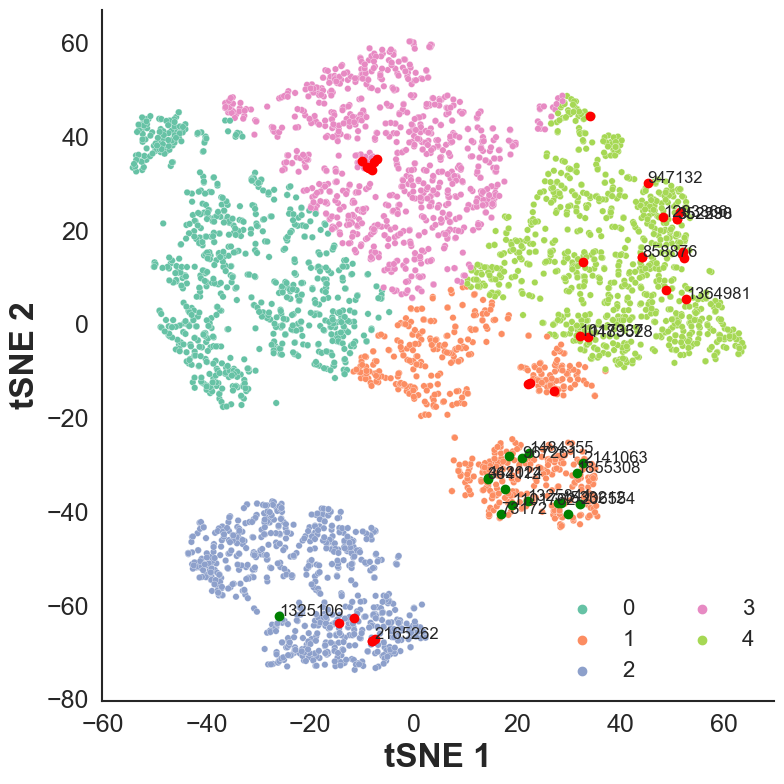

In [145]:
tsne_wscaffolds = pd.merge(tsne_result,library_scaffolds,on="mol_id")

plt.rcParams['axes.linewidth'] = 1.5
fig, ax = plt.subplots(figsize=(8,8))

ax=sns.scatterplot(x='TC1',y='TC2',data=tsne_result, hue='Cluster',s=22,palette=sns.color_palette("Set2", 8),linewidth=0.2,alpha=1)

# Plot nitrobenzenes
df_scaffold_nitro = tsne_wscaffolds[tsne_wscaffolds["scaffold"]=='nitro']
ax.plot(df_scaffold_nitro["TC1"],df_scaffold_nitro["TC2"], "og")

# Plot piperazines
df_scaffold_pip = tsne_wscaffolds[tsne_wscaffolds["scaffold"]=='piperazine']
ax.plot(df_scaffold_pip["TC1"],df_scaffold_pip["TC2"], "or")

for label in purchased : 
    plt.annotate(str(label), (table_bought[table_bought["mol_id"]==label].TC1, table_bought[table_bought["mol_id"]==label].TC2))
        

plt.xlabel ('tSNE 1',fontsize=24,fontweight='bold')
plt.ylabel ('tSNE 2',fontsize=24,fontweight='bold')
plt.tick_params ('both',width=2,labelsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles=handles[1:], labels=labels[1:])

plt.legend(loc='best',frameon=False,prop={'size': 16},ncol=2)

plt.tight_layout()
# plt.savefig('tsne-clusters-w-anottation.pdf')
plt.show()

## Export w/ image

In [ ]:
collections = []

for scaffold_id, scaffold_mol in scaffolds.items() : 
    
    scaffold_lib = library.copy()
    #print(scaffold_lib)
    scaffold_lib["keeper"] = scaffold_lib.apply(lambda x: matchesSubstructure([x["mol"]],scaffold_mol),axis=1)
    scaffold_lib = scaffold_lib[scaffold_lib["keeper"]]
    scaffold_lib["scaffold"] = scaffold_id
    collections.append(scaffold_lib)
    print(f"Found {len(scaffold_lib)} with {scaffold_id} scaffold")

    libraryExport = HTML(scaffold_lib[["mol_id","cluster","gene_name","gene_product","mol_thumb","Link"]].to_html(formatters={'mol_id':set_formatter,'mol_thumb': image_formatter, "Link":link_formatter}, escape=False))

    with open(f'libraryAgg_{scaffold_id}.html', 'w') as f:
        f.write(libraryExport.data)
        f.close()
        
resto = library[~library["cluster"].isin(list(pd.concat(collections)["cluster"]))]
print(f"{len(resto)} left with no specific scaffold")
libraryExport = HTML(resto[["mol_id",'smiles',"cluster","gene_name","gene_product","Link"]].to_html(formatters={'mol_id':set_formatter,'mol_thumb': image_formatter, "Link":link_formatter}, escape=False))
with open(f'libraryAgg_resto.html', 'w') as f:
    f.write(libraryExport.data)
    f.close()


In [159]:
# library.rename(columns={"gene_product_x" : "gene_product"}, inplace=True)
target_for_purchased_compounds = library[library["mol_id"].isin(purchased)].gene_name
purchased_library = library[library['gene_name'].isin(target_for_purchased_compounds)]


In [147]:
purchased_smiles = library[library["mol_id"].isin(purchased)][["mol_id","smiles"]]

In [160]:
pd.set_option('display.max_colwidth', None)
purchased_smiles

mol_id  \
3      73172   
5    2141063   
15    206554   
23   1017337   
65   1484355   
77   1489528   
108   947132   
118  1325106   
126  1855308   
128  1533212   
135  1325841   
163  1101762   
166   967261   
168   442024   
173  1293366   
227  1364981   
272  2165262   
278   364112   
323   858876   
371   352298   
372   352530   

                                                                           smiles  
3                                        O=C1C(=O)c2ccccc2c2c1cc(cc2)[N+](=O)[O-]  
5                        COCCn1c2nc3ccccc3nc2c(c1NC(=O)c1cccc(c1)[N+](=O)[O-])C#N  
15                                      O=C(N(CCN1CCCC1)C)Cc1cccc(c1)[N+](=O)[O-]  
23                            N#Cc1ccc(cc1)CNC(=O)CCCCCN1CCN(CC1)c1ccccc1c1ccccc1  
65                       [O-][N+](=O)c1cc(OCC(F)(F)F)c2c(c1)sn(c2=O)c1cccc(c1C)Cl  
77                                             Clc1ccc2c(c1)nccc2N1CCN(CC1)C(=O)C  
108                       O=C(N1CCN(CC1)Cc1cccc(c1)Oc1ccccc1)OC(C(F)(F)F)C(F)(F)F  
118                         O=C(c1cccc(c1)[N+](=O)[O-])Nc1nnc(s1)S(=O)(=O)N1CCCC1  
126                       CCc1ccc(cc1)OCC(=O)N/N=C/c1cc(ccc1N1CCOCC1)[N+](=O)[O-]  
128                          O=C(Nc1ccccc1Cl)CCC(=O)OCC(=O)c1ccc(cc1)[N+](=O)[O-]  
135                    O=C(C1CC1(c1cccc(c1)C)c1cccc(c1)C)Nc1ccc(cc1O)[N+](=O)[O-]  
163                              [O-][N+](=O)c1cc2c(O)cccc2c2c1c(cc1c2OCO1)C(=O)O  
166                S=C(NC(=O)c1ccc(cc1)[N+](=O)[O-])Nc1ccc(c(c1)c1nc2c(s1)cccc2)O  
168                             N=C1NC(=O)/C(=C/c2ccc(o2)c2ccccc2[N+](=O)[O-])/S1  
173                                     COc1cc(cc(c1OC)OC)C(=O)N1CCN(CC1)c1ccccn1  
227           OCCN1CCN(CC1)C(=O)CSc1nnc(n1c1ccccc1)CCCn1c(=O)c2cccc3c2c(c1=O)ccc3  
272  COc1ncc(cc1NS(=O)(=O)c1ccc(cc1F)F)c1ccc2c(c1)c(ccn2)C#CCN1CCN(CC1)S(=O)(=O)C  
278                         S=C1NC(=O)/C(=C/c2ccc(o2)c2ccc(cc2Br)[N+](=O)[O-])/S1  
323                                     O=C1C(=O)c2c(N1CN1CCN(CC1)Cc1ccccc1)cccc2  
371                                  Oc1ccc(cc1)N1CCN(CC1)C1CC(=O)N(C1=O)c1ccccc1  
372                                 Oc1ccc(cc1)N1CCN(CC1)C1CC(=O)N(C1=O)Cc1ccccc1

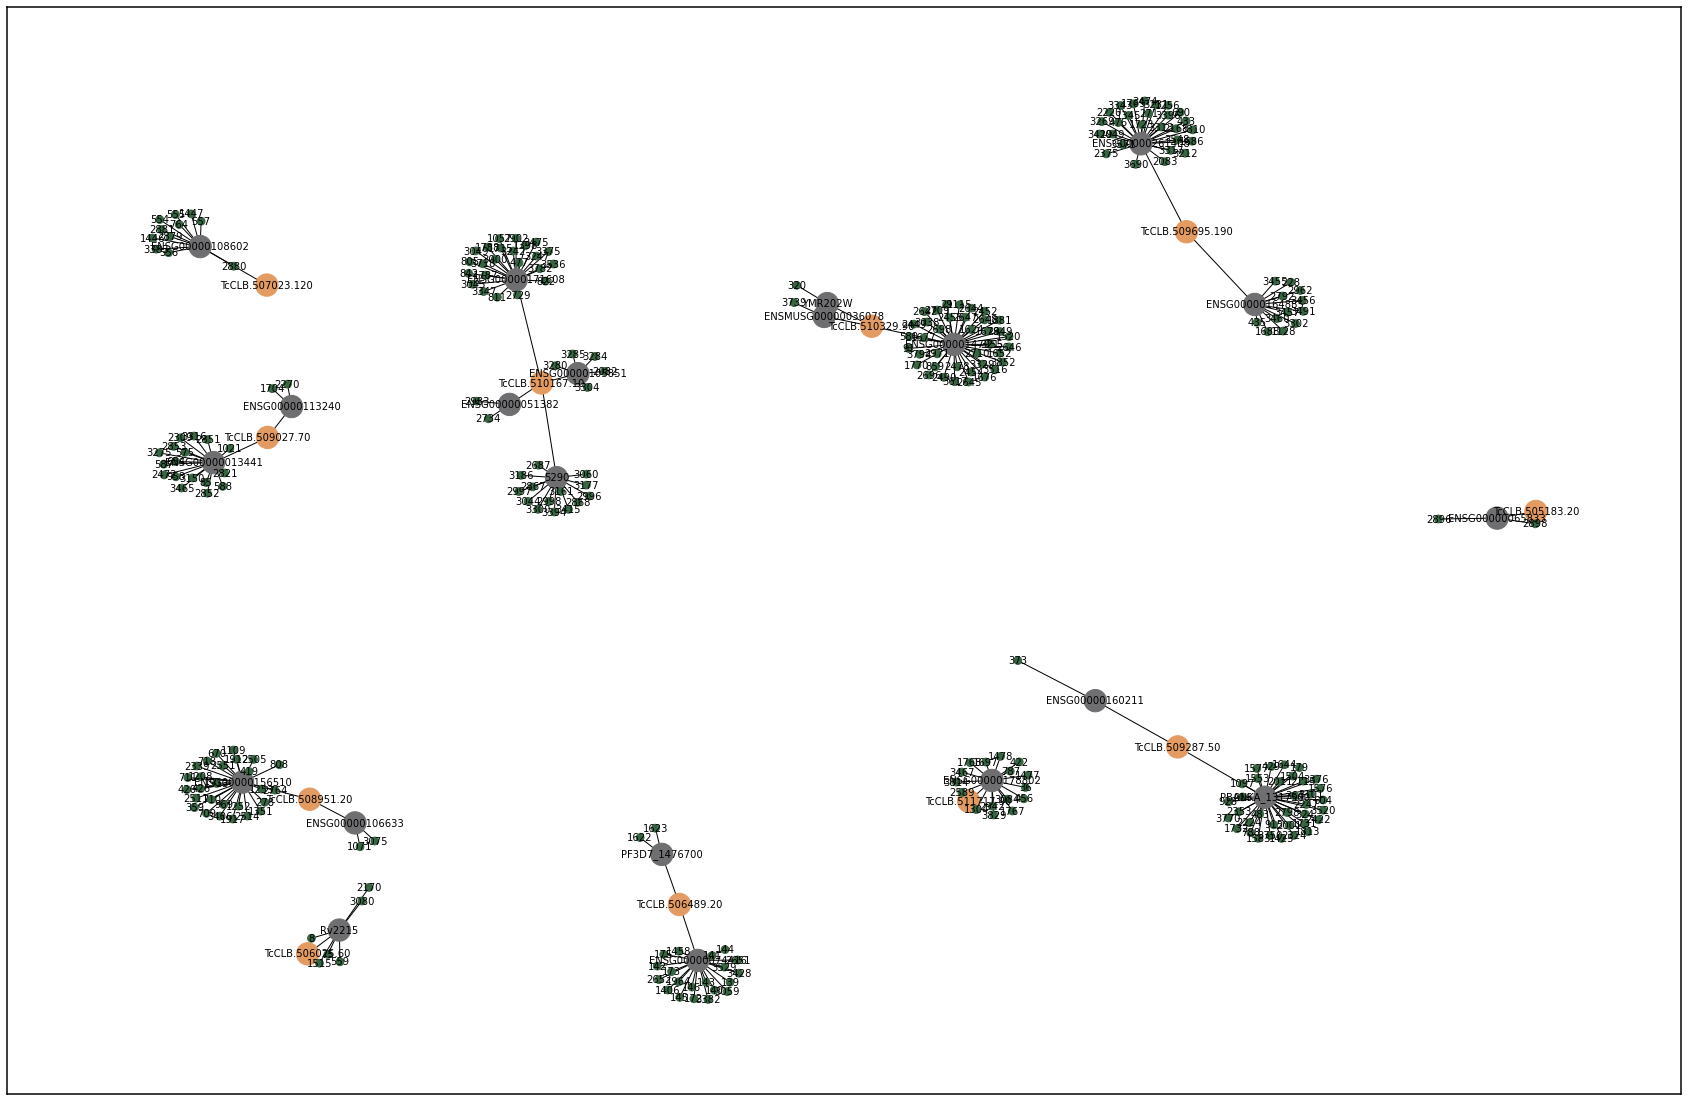

In [ ]:
import networkx as nx
import re 


G = nx.Graph()

for index, row in purchased_library.iterrows() : 

    known_target = row.known_target
    known_target_species = row.known_target_species
    tcr_target = row.gene_name
    tcr_product = row.gene_product
    cluster = row.cluster
    mols = res = row.mol_id

    # Nodes
    G.add_node(known_target, type='target', species='tcr', color="#6f6f72",size=500)
    
    G.add_node(tcr_target, type='target', species=known_target_species, color='#e39b62', size=500)

    G.add_node(cluster, type='drug', mol=mols, color= '#386643', size=60 )

    # T2T Edge
    G.add_edge(known_target,tcr_target,length="1")

    # D2T Edge
    G.add_edge(known_target,cluster,length="1000")


fig, axs = plt.subplots(figsize=(30,20))

pos = nx.spring_layout(G) # positions for all nodes

color_map = []
size_map = []

for node, data in G.nodes(data=True): 
    color_map.append(data['color'])
    size_map.append(data['size'])

# nodes    
nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=size_map)

# edges
nx.draw_networkx_edges(G,pos,width=1)

plt.savefig("graph-no-labels-purchased.svg")

# Labels
nx.draw_networkx_labels(G,pos,font_size=10,font_family='sans-serif')

plt.savefig("graph-purchased.svg")

plt.show() # display

